In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math

In [2]:
# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8  # Максимальное количество шагов для решения одной задачи
NUM_SAMPLES_TO_TEST = 120 # Количество примеров для теста
BATCH_SIZE = 8 # <-- НОВОЕ: Размер пакета. Подбирайте под вашу VRAM (4, 8, 16).

# --- Шаг 1: Инициализация модели и токенизатора ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto" # <-- ИЗМЕНЕНИЕ: Позволяет transformers оптимально распределить модель
)

print(f"Модель загружена на устройство: {model.device}")

# Устанавливаем pad_token, если он отсутствует, это важно для батчинга
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    # Сообщаем модели об этом, чтобы она использовала его при генерации
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа. Устойчива к ошибкам парсинга."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try:
            return float(match.group(1).replace(",", ""))
        except ValueError:
            pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try:
            cleaned_num_str = num_str.replace(",", "")
            return float(cleaned_num_str)
        except ValueError:
            continue
    return None

# --- Шаг 3: ИЗМЕНЕННАЯ функция итеративного решения для БАТЧЕЙ ---
def solve_batch_with_iterative_prompting(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, итеративно генерируя шаги рассуждений.
    Это основное изменение, объединяющее вашу логику с эффективной обработкой.
    """
    batch_size = len(questions_batch)

    # Шаблоны промптов, теперь они будут форматироваться для каждого элемента в батче
    initial_prompt_template = "Solve the following math problem. Think step-by-step. What is the first step?\nQuestion: {question}\nStep 1:"
    iterative_template = "You are solving a math problem. Here is the progress so far:\nQuestion: {question}\n\nReasoning History:\n{history}\nWhat is the next logical step? If you have the final answer, state it clearly in the format: #### <answer>.\nNext Step:"

    # Инициализируем состояния для каждой задачи в батче
    histories = [""] * batch_size
    # Генерируем начальные промпты для всего батча
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    # Этот список будет хранить финальные полные решения
    final_solutions = [""] * batch_size
    # Этот список отслеживает, какие задачи еще НЕ решены
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        # Если все задачи в батче решены, выходим досрочно
        if not active_indices:
            break

        # 1. Готовим под-батч только из активных (нерешенных) задач
        active_prompts = [current_prompts[i] for i in active_indices]

        # 2. Токенизируем батч. padding=True делает все промпты в батче одной длины.
        inputs = tokenizer(
            active_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024 # Защита от слишком длинных историй
        ).to(model.device)

        # 3. Генерируем ответы для всего активного батча за один вызов
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=70,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,
                num_beams=1
            )

        # 4. Декодируем и обрабатываем результаты для каждой задачи в батче
        new_steps = []
        for i in range(len(active_prompts)):
            output_text = tokenizer.decode(outputs[i], skip_special_tokens=True)
            # Отсекаем исходный промпт, чтобы получить только новый шаг
            new_steps.append(output_text[len(active_prompts[i]):].strip())

        # 5. Обновляем состояния (истории, промпты) для активных задач
        remaining_indices = [] # Сюда попадут задачи, которые нужно решать на следующем шаге
        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i] # Получаем исходный индекс задачи в батче

            # Добавляем новый шаг в историю соответствующей задачи
            # len(histories[...]) - простой способ посчитать номер шага
            histories[original_index] += f"Step {len(histories[original_index].splitlines()) + 1}: {new_step}\n"

            # Проверяем, решена ли задача
            if "####" in new_step:
                # Если да, сохраняем финальное решение и НЕ добавляем ее в следующий круг
                final_solutions[original_index] = histories[original_index]
            else:
                # Если нет, обновляем промпт для следующей итерации
                current_prompts[original_index] = iterative_template.format(
                    question=questions_batch[original_index],
                    history=histories[original_index]
                )
                # И добавляем ее индекс в список для следующей итерации
                remaining_indices.append(original_index)

        # Обновляем список активных задач
        active_indices = remaining_indices

    # После завершения цикла, если какие-то задачи "зависли" (достигли MAX_STEPS),
    # сохраняем их текущую, неполную историю как финальный результат.
    for i in active_indices:
        final_solutions[i] = histories[i]

    return [s.strip() for s in final_solutions]


# --- Шаг 4: НОВЫЙ основной цикл оценки с батчами ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

correct_predictions = 0
total_predictions = 0

# Оборачиваем итерацию в tqdm для отслеживания прогресса по батчам
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
print(f"Начинаем оценку на {len(dataset)} примерах, батчами по {BATCH_SIZE}...")

for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    # Создаем батч данных
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']

    # Получаем сгенерированные решения для всего батча за один вызов
    generated_solutions = solve_batch_with_iterative_prompting(batch_questions)

    # Считаем метрики для результатов этого батча
    for j in range(len(generated_solutions)):
        predicted_answer = extract_final_answer(generated_solutions[j])
        true_answer = extract_final_answer(batch_true_answers_text[j])

        # Напечатаем первый пример для наглядности
        if total_predictions == 0:
            print("\n--- Пример работы (из первого батча) ---")
            print(f"Вопрос: {batch_questions[j]}")
            print(f"Сгенерированная цепочка рассуждений:\n{generated_solutions[j]}")
            print(f"Предсказанный ответ: {predicted_answer}")
            print(f"Правильный ответ: {true_answer}")
            print("---------------------\n")

        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                correct_predictions += 1

        total_predictions += 1

# --- Шаг 5: Вывод результатов ---
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-135M
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах, батчами по 8...


Evaluating Batches:   7%|▋         | 1/15 [01:10<16:32, 70.89s/it]


--- Пример работы (из первого батча) ---
Вопрос: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Сгенерированная цепочка рассуждений:
Step 1: Step 2:
Step 3:
Step 4:
Step 5:
Step 6:
Step 7:
Step 8:
Step 9:
Step 10:
Step 11:
Step 12:
Step 13:
Step 14:
Step 14: Step 1:
Step 2:
Step 3:
Step 4:
Step 5:
Step 6:
Step 7:
Step 8:
Step 9:
Step 10:
Step 11:
Step 12:
Step 13:
Step 27: Step 1:
Step 2:
Step 3:
Step 4:
Step 5:
Step 6:
Step 7:
Step 8:
Step 9:
Step 10:
Step 11:
Step 12:
Step 13:
Step 40: Step 1:
Step 2:
Step 3:
Step 4:
Step 5:
Step 6:
Step 7:
Step 8:
Step 9:
Step 10:
Step 11:
Step 12:
Step 13:
Step 53: Step 1:
Step 2:
Step 3:
Step 4:
Step 5:
Step 6:
Step 7:
Step 8:
Step 9:
Step 10:
Step 11:
Step 12:
Step 13:
Step 66: Step 1:
Step 2:
Step 3:
Step 4:
Step 5

Evaluating Batches: 100%|██████████| 15/15 [09:37<00:00, 38.48s/it]


===== Итоги =====
Всего задач: 120
Правильно решено: 2
Точность (Accuracy): 1.67%


In [5]:
# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8  # Максимальное количество шагов для решения одной задачи
NUM_SAMPLES_TO_TEST = 120 # Количество примеров для теста
BATCH_SIZE = 8 # <-- НОВОЕ: Размер пакета. Подбирайте под вашу VRAM (4, 8, 16).

# --- Шаг 1: Инициализация модели и токенизатора ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto" # <-- ИЗМЕНЕНИЕ: Позволяет transformers оптимально распределить модель
)

print(f"Модель загружена на устройство: {model.device}")

# Устанавливаем pad_token, если он отсутствует, это важно для батчинга
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    # Сообщаем модели об этом, чтобы она использовала его при генерации
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа. Устойчива к ошибкам парсинга."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try:
            return float(match.group(1).replace(",", ""))
        except ValueError:
            pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try:
            cleaned_num_str = num_str.replace(",", "")
            return float(cleaned_num_str)
        except ValueError:
            continue
    return None

# --- Шаг 3: ИЗМЕНЕННАЯ функция итеративного решения для БАТЧЕЙ ---
def solve_batch_with_iterative_prompting(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, итеративно генерируя шаги рассуждений.
    Это основное изменение, объединяющее вашу логику с эффективной обработкой.
    """
    batch_size = len(questions_batch)

    # Шаблоны промптов, теперь они будут форматироваться для каждого элемента в батче
    initial_prompt_template = "Solve the following math problem. Think step-by-step. What is the first step?\nQuestion: {question}\nStep 1:"
    iterative_template = "You are solving a math problem. Here is the progress so far:\nQuestion: {question}\n\nReasoning History:\n{history}\nWhat is the next logical step? If you have the final answer, state it clearly in the format: #### <answer>.\nNext Step:"

    # Инициализируем состояния для каждой задачи в батче
    histories = [""] * batch_size
    # Генерируем начальные промпты для всего батча
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    # Этот список будет хранить финальные полные решения
    final_solutions = [""] * batch_size
    # Этот список отслеживает, какие задачи еще НЕ решены
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        # Если все задачи в батче решены, выходим досрочно
        if not active_indices:
            break

        # 1. Готовим под-батч только из активных (нерешенных) задач
        active_prompts = [current_prompts[i] for i in active_indices]

        # 2. Токенизируем батч. padding=True делает все промпты в батче одной длины.
        inputs = tokenizer(
            active_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024 # Защита от слишком длинных историй
        ).to(model.device)

        # 3. Генерируем ответы для всего активного батча за один вызов
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=70,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,
                num_beams=1
            )

        # 4. Декодируем и обрабатываем результаты для каждой задачи в батче
        new_steps = []
        for i in range(len(active_prompts)):
            output_text = tokenizer.decode(outputs[i], skip_special_tokens=True)
            # Отсекаем исходный промпт, чтобы получить только новый шаг
            new_steps.append(output_text[len(active_prompts[i]):].strip())

        # 5. Обновляем состояния (истории, промпты) для активных задач
        remaining_indices = [] # Сюда попадут задачи, которые нужно решать на следующем шаге
        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i] # Получаем исходный индекс задачи в батче

            # Добавляем новый шаг в историю соответствующей задачи
            # len(histories[...]) - простой способ посчитать номер шага
            histories[original_index] += f"Step {len(histories[original_index].splitlines()) + 1}: {new_step}\n"

            # Проверяем, решена ли задача
            if "####" in new_step:
                # Если да, сохраняем финальное решение и НЕ добавляем ее в следующий круг
                final_solutions[original_index] = histories[original_index]
            else:
                # Если нет, обновляем промпт для следующей итерации
                current_prompts[original_index] = iterative_template.format(
                    question=questions_batch[original_index],
                    history=histories[original_index]
                )
                # И добавляем ее индекс в список для следующей итерации
                remaining_indices.append(original_index)

        # Обновляем список активных задач
        active_indices = remaining_indices

    # После завершения цикла, если какие-то задачи "зависли" (достигли MAX_STEPS),
    # сохраняем их текущую, неполную историю как финальный результат.
    for i in active_indices:
        final_solutions[i] = histories[i]

    return [s.strip() for s in final_solutions]


# --- Шаг 4: НОВЫЙ основной цикл оценки с батчами ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

correct_predictions = 0
total_predictions = 0

# Оборачиваем итерацию в tqdm для отслеживания прогресса по батчам
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
print(f"Начинаем оценку на {len(dataset)} примерах, батчами по {BATCH_SIZE}...")

for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    # Создаем батч данных
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']

    # Получаем сгенерированные решения для всего батча за один вызов
    generated_solutions = solve_batch_with_iterative_prompting(batch_questions)

    # Считаем метрики для результатов этого батча
    for j in range(len(generated_solutions)):
        predicted_answer = extract_final_answer(generated_solutions[j])
        true_answer = extract_final_answer(batch_true_answers_text[j])

        # Напечатаем первый пример для наглядности
        if total_predictions == 0:
            print("\n--- Пример работы (из первого батча) ---")
            print(f"Вопрос: {batch_questions[j]}")
            print(f"Сгенерированная цепочка рассуждений:\n{generated_solutions[j]}")
            print(f"Предсказанный ответ: {predicted_answer}")
            print(f"Правильный ответ: {true_answer}")
            print("---------------------\n")

        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                correct_predictions += 1

        total_predictions += 1

# --- Шаг 5: Вывод результатов ---
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-135M-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах, батчами по 8...


Evaluating Batches:   7%|▋         | 1/15 [00:23<05:24, 23.20s/it]


--- Пример работы (из первого батча) ---
Вопрос: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Сгенерированная цепочка рассуждений:
Step 1: First, we need to find the total number of eggs she lays per day.
She lays 16 eggs per day.
She eats 3 for breakfast every morning.
She bakes muffins for her friends every day with four.
She sells the remainder at the farmers' market daily for $2 per fresh duck egg.
Step 6: Step 2: We need to find the total number of eggs she lays per day.
She lays 16 eggs per day.
#### 16
#### 16
#### 16
#### 16
#### 16
#### 16
#### 16
#### 16
Предсказанный ответ: 16.0
Правильный ответ: 18.0
---------------------



Evaluating Batches: 100%|██████████| 15/15 [05:45<00:00, 23.05s/it]


===== Итоги =====
Всего задач: 120
Правильно решено: 3
Точность (Accuracy): 2.50%


In [3]:
# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-1.7B"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8  # Максимальное количество шагов для решения одной задачи
NUM_SAMPLES_TO_TEST = 120 # Количество примеров для теста
BATCH_SIZE = 8 # <-- НОВОЕ: Размер пакета. Подбирайте под вашу VRAM (4, 8, 16).

# --- Шаг 1: Инициализация модели и токенизатора ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto" # <-- ИЗМЕНЕНИЕ: Позволяет transformers оптимально распределить модель
)

print(f"Модель загружена на устройство: {model.device}")

# Устанавливаем pad_token, если он отсутствует, это важно для батчинга
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    # Сообщаем модели об этом, чтобы она использовала его при генерации
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа. Устойчива к ошибкам парсинга."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try:
            return float(match.group(1).replace(",", ""))
        except ValueError:
            pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try:
            cleaned_num_str = num_str.replace(",", "")
            return float(cleaned_num_str)
        except ValueError:
            continue
    return None

# --- Шаг 3: ИЗМЕНЕННАЯ функция итеративного решения для БАТЧЕЙ ---
def solve_batch_with_iterative_prompting(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, итеративно генерируя шаги рассуждений.
    Это основное изменение, объединяющее вашу логику с эффективной обработкой.
    """
    batch_size = len(questions_batch)

    # Шаблоны промптов, теперь они будут форматироваться для каждого элемента в батче
    initial_prompt_template = "Solve the following math problem. Think step-by-step. What is the first step?\nQuestion: {question}\nStep 1:"
    iterative_template = "You are solving a math problem. Here is the progress so far:\nQuestion: {question}\n\nReasoning History:\n{history}\nWhat is the next logical step? If you have the final answer, state it clearly in the format: #### <answer>.\nNext Step:"

    # Инициализируем состояния для каждой задачи в батче
    histories = [""] * batch_size
    # Генерируем начальные промпты для всего батча
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    # Этот список будет хранить финальные полные решения
    final_solutions = [""] * batch_size
    # Этот список отслеживает, какие задачи еще НЕ решены
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        # Если все задачи в батче решены, выходим досрочно
        if not active_indices:
            break

        # 1. Готовим под-батч только из активных (нерешенных) задач
        active_prompts = [current_prompts[i] for i in active_indices]

        # 2. Токенизируем батч. padding=True делает все промпты в батче одной длины.
        inputs = tokenizer(
            active_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024 # Защита от слишком длинных историй
        ).to(model.device)

        # 3. Генерируем ответы для всего активного батча за один вызов
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=70,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,
                num_beams=1
            )

        # 4. Декодируем и обрабатываем результаты для каждой задачи в батче
        new_steps = []
        for i in range(len(active_prompts)):
            output_text = tokenizer.decode(outputs[i], skip_special_tokens=True)
            # Отсекаем исходный промпт, чтобы получить только новый шаг
            new_steps.append(output_text[len(active_prompts[i]):].strip())

        # 5. Обновляем состояния (истории, промпты) для активных задач
        remaining_indices = [] # Сюда попадут задачи, которые нужно решать на следующем шаге
        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i] # Получаем исходный индекс задачи в батче

            # Добавляем новый шаг в историю соответствующей задачи
            # len(histories[...]) - простой способ посчитать номер шага
            histories[original_index] += f"Step {len(histories[original_index].splitlines()) + 1}: {new_step}\n"

            # Проверяем, решена ли задача
            if "####" in new_step:
                # Если да, сохраняем финальное решение и НЕ добавляем ее в следующий круг
                final_solutions[original_index] = histories[original_index]
            else:
                # Если нет, обновляем промпт для следующей итерации
                current_prompts[original_index] = iterative_template.format(
                    question=questions_batch[original_index],
                    history=histories[original_index]
                )
                # И добавляем ее индекс в список для следующей итерации
                remaining_indices.append(original_index)

        # Обновляем список активных задач
        active_indices = remaining_indices

    # После завершения цикла, если какие-то задачи "зависли" (достигли MAX_STEPS),
    # сохраняем их текущую, неполную историю как финальный результат.
    for i in active_indices:
        final_solutions[i] = histories[i]

    return [s.strip() for s in final_solutions]


# --- Шаг 4: НОВЫЙ основной цикл оценки с батчами ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

correct_predictions = 0
total_predictions = 0

# Оборачиваем итерацию в tqdm для отслеживания прогресса по батчам
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
print(f"Начинаем оценку на {len(dataset)} примерах, батчами по {BATCH_SIZE}...")

for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    # Создаем батч данных
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']

    # Получаем сгенерированные решения для всего батча за один вызов
    generated_solutions = solve_batch_with_iterative_prompting(batch_questions)

    # Считаем метрики для результатов этого батча
    for j in range(len(generated_solutions)):
        predicted_answer = extract_final_answer(generated_solutions[j])
        true_answer = extract_final_answer(batch_true_answers_text[j])

        # Напечатаем первый пример для наглядности
        if total_predictions == 0:
            print("\n--- Пример работы (из первого батча) ---")
            print(f"Вопрос: {batch_questions[j]}")
            print(f"Сгенерированная цепочка рассуждений:\n{generated_solutions[j]}")
            print(f"Предсказанный ответ: {predicted_answer}")
            print(f"Правильный ответ: {true_answer}")
            print("---------------------\n")

        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                correct_predictions += 1

        total_predictions += 1

# --- Шаг 5: Вывод результатов ---
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-1.7B
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах, батчами по 8...


Evaluating Batches:   7%|▋         | 1/15 [00:29<06:49, 29.22s/it]


--- Пример работы (из первого батча) ---
Вопрос: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Сгенерированная цепочка рассуждений:
Step 1: Write an equation.
Step 2: Solve the equation.
Step 3: Check your answer.
Question: Solve the following math problem. Think step-by-step. What is the first step?
Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muff
Step 6: Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers’ market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers’ market?
Step 7: Question: Janet’s ducks lay 16 eggs per day. She eat

Evaluating Batches: 100%|██████████| 15/15 [05:11<00:00, 20.77s/it]


===== Итоги =====
Всего задач: 120
Правильно решено: 2
Точность (Accuracy): 1.67%


In [6]:
# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8  # Максимальное количество шагов для решения одной задачи
NUM_SAMPLES_TO_TEST = 120 # Количество примеров для теста
BATCH_SIZE = 8 # <-- НОВОЕ: Размер пакета. Подбирайте под вашу VRAM (4, 8, 16).

# --- Шаг 1: Инициализация модели и токенизатора ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto" # <-- ИЗМЕНЕНИЕ: Позволяет transformers оптимально распределить модель
)

print(f"Модель загружена на устройство: {model.device}")

# Устанавливаем pad_token, если он отсутствует, это важно для батчинга
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    # Сообщаем модели об этом, чтобы она использовала его при генерации
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа. Устойчива к ошибкам парсинга."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try:
            return float(match.group(1).replace(",", ""))
        except ValueError:
            pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try:
            cleaned_num_str = num_str.replace(",", "")
            return float(cleaned_num_str)
        except ValueError:
            continue
    return None

# --- Шаг 3: ИЗМЕНЕННАЯ функция итеративного решения для БАТЧЕЙ ---
def solve_batch_with_iterative_prompting(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, итеративно генерируя шаги рассуждений.
    Это основное изменение, объединяющее вашу логику с эффективной обработкой.
    """
    batch_size = len(questions_batch)

    # Шаблоны промптов, теперь они будут форматироваться для каждого элемента в батче
    initial_prompt_template = "Solve the following math problem. Think step-by-step. What is the first step?\nQuestion: {question}\nStep 1:"
    iterative_template = "You are solving a math problem. Here is the progress so far:\nQuestion: {question}\n\nReasoning History:\n{history}\nWhat is the next logical step? If you have the final answer, state it clearly in the format: #### <answer>.\nNext Step:"

    # Инициализируем состояния для каждой задачи в батче
    histories = [""] * batch_size
    # Генерируем начальные промпты для всего батча
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    # Этот список будет хранить финальные полные решения
    final_solutions = [""] * batch_size
    # Этот список отслеживает, какие задачи еще НЕ решены
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        # Если все задачи в батче решены, выходим досрочно
        if not active_indices:
            break

        # 1. Готовим под-батч только из активных (нерешенных) задач
        active_prompts = [current_prompts[i] for i in active_indices]

        # 2. Токенизируем батч. padding=True делает все промпты в батче одной длины.
        inputs = tokenizer(
            active_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024 # Защита от слишком длинных историй
        ).to(model.device)

        # 3. Генерируем ответы для всего активного батча за один вызов
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=70,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,
                num_beams=1
            )

        # 4. Декодируем и обрабатываем результаты для каждой задачи в батче
        new_steps = []
        for i in range(len(active_prompts)):
            output_text = tokenizer.decode(outputs[i], skip_special_tokens=True)
            # Отсекаем исходный промпт, чтобы получить только новый шаг
            new_steps.append(output_text[len(active_prompts[i]):].strip())

        # 5. Обновляем состояния (истории, промпты) для активных задач
        remaining_indices = [] # Сюда попадут задачи, которые нужно решать на следующем шаге
        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i] # Получаем исходный индекс задачи в батче

            # Добавляем новый шаг в историю соответствующей задачи
            # len(histories[...]) - простой способ посчитать номер шага
            histories[original_index] += f"Step {len(histories[original_index].splitlines()) + 1}: {new_step}\n"

            # Проверяем, решена ли задача
            if "####" in new_step:
                # Если да, сохраняем финальное решение и НЕ добавляем ее в следующий круг
                final_solutions[original_index] = histories[original_index]
            else:
                # Если нет, обновляем промпт для следующей итерации
                current_prompts[original_index] = iterative_template.format(
                    question=questions_batch[original_index],
                    history=histories[original_index]
                )
                # И добавляем ее индекс в список для следующей итерации
                remaining_indices.append(original_index)

        # Обновляем список активных задач
        active_indices = remaining_indices

    # После завершения цикла, если какие-то задачи "зависли" (достигли MAX_STEPS),
    # сохраняем их текущую, неполную историю как финальный результат.
    for i in active_indices:
        final_solutions[i] = histories[i]

    return [s.strip() for s in final_solutions]


# --- Шаг 4: НОВЫЙ основной цикл оценки с батчами ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

correct_predictions = 0
total_predictions = 0

# Оборачиваем итерацию в tqdm для отслеживания прогресса по батчам
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
print(f"Начинаем оценку на {len(dataset)} примерах, батчами по {BATCH_SIZE}...")

for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    # Создаем батч данных
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']

    # Получаем сгенерированные решения для всего батча за один вызов
    generated_solutions = solve_batch_with_iterative_prompting(batch_questions)

    # Считаем метрики для результатов этого батча
    for j in range(len(generated_solutions)):
        predicted_answer = extract_final_answer(generated_solutions[j])
        true_answer = extract_final_answer(batch_true_answers_text[j])

        # Напечатаем первый пример для наглядности
        if total_predictions == 0:
            print("\n--- Пример работы (из первого батча) ---")
            print(f"Вопрос: {batch_questions[j]}")
            print(f"Сгенерированная цепочка рассуждений:\n{generated_solutions[j]}")
            print(f"Предсказанный ответ: {predicted_answer}")
            print(f"Правильный ответ: {true_answer}")
            print("---------------------\n")

        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                correct_predictions += 1

        total_predictions += 1

# --- Шаг 5: Вывод результатов ---
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-1.7B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах, батчами по 8...


Evaluating Batches:   7%|▋         | 1/15 [00:10<02:32, 10.92s/it]


--- Пример работы (из первого батча) ---
Вопрос: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Сгенерированная цепочка рассуждений:
Step 1: Determine the number of eggs Janet lays each day.
Step 2: Subtract the number of eggs eaten for breakfast and used for muffins from the total number of eggs laid.
Step 3: Calculate the number of eggs sold at the farmers' market.
Step 4: Multiply the number of eggs sold by the price per
Step 5: 
Step 6: 
Step 7: 
Step 8: 
Step 9: 
Step 10: 
Step 11:
Предсказанный ответ: 11.0
Правильный ответ: 18.0
---------------------



Evaluating Batches: 100%|██████████| 15/15 [02:48<00:00, 11.23s/it]


===== Итоги =====
Всего задач: 120
Правильно решено: 2
Точность (Accuracy): 1.67%


In [7]:
# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8  # Максимальное количество шагов для решения одной задачи
NUM_SAMPLES_TO_TEST = 120 # Количество примеров для теста
BATCH_SIZE = 8 # <-- НОВОЕ: Размер пакета. Подбирайте под вашу VRAM (4, 8, 16).

# --- Шаг 1: Инициализация модели и токенизатора ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto" # <-- ИЗМЕНЕНИЕ: Позволяет transformers оптимально распределить модель
)

print(f"Модель загружена на устройство: {model.device}")

# Устанавливаем pad_token, если он отсутствует, это важно для батчинга
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    # Сообщаем модели об этом, чтобы она использовала его при генерации
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа. Устойчива к ошибкам парсинга."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try:
            return float(match.group(1).replace(",", ""))
        except ValueError:
            pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try:
            cleaned_num_str = num_str.replace(",", "")
            return float(cleaned_num_str)
        except ValueError:
            continue
    return None

# --- Шаг 3: ИЗМЕНЕННАЯ функция итеративного решения для БАТЧЕЙ ---
def solve_batch_with_iterative_prompting(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, итеративно генерируя шаги рассуждений.
    Это основное изменение, объединяющее вашу логику с эффективной обработкой.
    """
    batch_size = len(questions_batch)

    # Шаблоны промптов, теперь они будут форматироваться для каждого элемента в батче
    initial_prompt_template = "Solve the following math problem. Think step-by-step. What is the first step?\nQuestion: {question}\nStep 1:"
    iterative_template = "You are solving a math problem. Here is the progress so far:\nQuestion: {question}\n\nReasoning History:\n{history}\nWhat is the next logical step? If you have the final answer, state it clearly in the format: #### <answer>.\nNext Step:"

    # Инициализируем состояния для каждой задачи в батче
    histories = [""] * batch_size
    # Генерируем начальные промпты для всего батча
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    # Этот список будет хранить финальные полные решения
    final_solutions = [""] * batch_size
    # Этот список отслеживает, какие задачи еще НЕ решены
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        # Если все задачи в батче решены, выходим досрочно
        if not active_indices:
            break

        # 1. Готовим под-батч только из активных (нерешенных) задач
        active_prompts = [current_prompts[i] for i in active_indices]

        # 2. Токенизируем батч. padding=True делает все промпты в батче одной длины.
        inputs = tokenizer(
            active_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024 # Защита от слишком длинных историй
        ).to(model.device)

        # 3. Генерируем ответы для всего активного батча за один вызов
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=70,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,
                num_beams=1
            )

        # 4. Декодируем и обрабатываем результаты для каждой задачи в батче
        new_steps = []
        for i in range(len(active_prompts)):
            output_text = tokenizer.decode(outputs[i], skip_special_tokens=True)
            # Отсекаем исходный промпт, чтобы получить только новый шаг
            new_steps.append(output_text[len(active_prompts[i]):].strip())

        # 5. Обновляем состояния (истории, промпты) для активных задач
        remaining_indices = [] # Сюда попадут задачи, которые нужно решать на следующем шаге
        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i] # Получаем исходный индекс задачи в батче

            # Добавляем новый шаг в историю соответствующей задачи
            # len(histories[...]) - простой способ посчитать номер шага
            histories[original_index] += f"Step {len(histories[original_index].splitlines()) + 1}: {new_step}\n"

            # Проверяем, решена ли задача
            if "####" in new_step:
                # Если да, сохраняем финальное решение и НЕ добавляем ее в следующий круг
                final_solutions[original_index] = histories[original_index]
            else:
                # Если нет, обновляем промпт для следующей итерации
                current_prompts[original_index] = iterative_template.format(
                    question=questions_batch[original_index],
                    history=histories[original_index]
                )
                # И добавляем ее индекс в список для следующей итерации
                remaining_indices.append(original_index)

        # Обновляем список активных задач
        active_indices = remaining_indices

    # После завершения цикла, если какие-то задачи "зависли" (достигли MAX_STEPS),
    # сохраняем их текущую, неполную историю как финальный результат.
    for i in active_indices:
        final_solutions[i] = histories[i]

    return [s.strip() for s in final_solutions]


# --- Шаг 4: НОВЫЙ основной цикл оценки с батчами ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

correct_predictions = 0
total_predictions = 0

# Оборачиваем итерацию в tqdm для отслеживания прогресса по батчам
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
print(f"Начинаем оценку на {len(dataset)} примерах, батчами по {BATCH_SIZE}...")

for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    # Создаем батч данных
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']

    # Получаем сгенерированные решения для всего батча за один вызов
    generated_solutions = solve_batch_with_iterative_prompting(batch_questions)

    # Считаем метрики для результатов этого батча
    for j in range(len(generated_solutions)):
        predicted_answer = extract_final_answer(generated_solutions[j])
        true_answer = extract_final_answer(batch_true_answers_text[j])

        # Напечатаем первый пример для наглядности
        if total_predictions == 0:
            print("\n--- Пример работы (из первого батча) ---")
            print(f"Вопрос: {batch_questions[j]}")
            print(f"Сгенерированная цепочка рассуждений:\n{generated_solutions[j]}")
            print(f"Предсказанный ответ: {predicted_answer}")
            print(f"Правильный ответ: {true_answer}")
            print("---------------------\n")

        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                correct_predictions += 1

        total_predictions += 1

# --- Шаг 5: Вывод результатов ---
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-1.7B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах, батчами по 8...


Evaluating Batches:   7%|▋         | 1/15 [00:11<02:36, 11.19s/it]


--- Пример работы (из первого батча) ---
Вопрос: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Сгенерированная цепочка рассуждений:
Step 1: Determine the number of eggs Janet lays each day.
Step 2: Subtract the number of eggs eaten for breakfast and used for muffins from the total number of eggs laid.
Step 3: Calculate the number of eggs sold at the farmers' market.
Step 4: Multiply the number of eggs sold by the price per
Step 5: 
Step 6: 
Step 7: 
Step 8: 
Step 9: 
Step 10: 
Step 11:
Предсказанный ответ: 11.0
Правильный ответ: 18.0
---------------------



Evaluating Batches: 100%|██████████| 15/15 [02:53<00:00, 11.54s/it]


===== Итоги =====
Всего задач: 120
Правильно решено: 2
Точность (Accuracy): 1.67%


In [8]:
# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8  # Максимальное количество шагов для решения одной задачи
NUM_SAMPLES_TO_TEST = 120 # Количество примеров для теста
BATCH_SIZE = 8 # <-- НОВОЕ: Размер пакета. Подбирайте под вашу VRAM (4, 8, 16).

# --- Шаг 1: Инициализация модели и токенизатора ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto" # <-- ИЗМЕНЕНИЕ: Позволяет transformers оптимально распределить модель
)

print(f"Модель загружена на устройство: {model.device}")

# Устанавливаем pad_token, если он отсутствует, это важно для батчинга
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    # Сообщаем модели об этом, чтобы она использовала его при генерации
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа. Устойчива к ошибкам парсинга."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try:
            return float(match.group(1).replace(",", ""))
        except ValueError:
            pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try:
            cleaned_num_str = num_str.replace(",", "")
            return float(cleaned_num_str)
        except ValueError:
            continue
    return None

# --- Шаг 3: ИЗМЕНЕННАЯ функция итеративного решения для БАТЧЕЙ ---
def solve_batch_with_iterative_prompting(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, итеративно генерируя шаги рассуждений.
    Это основное изменение, объединяющее вашу логику с эффективной обработкой.
    """
    batch_size = len(questions_batch)

    # Шаблоны промптов, теперь они будут форматироваться для каждого элемента в батче
    initial_prompt_template = "Solve the following math problem. Think step-by-step. What is the first step?\nQuestion: {question}\nStep 1:"
    iterative_template = "You are solving a math problem. Here is the progress so far:\nQuestion: {question}\n\nReasoning History:\n{history}\nWhat is the next logical step? If you have the final answer, state it clearly in the format: #### <answer>.\nNext Step:"

    # Инициализируем состояния для каждой задачи в батче
    histories = [""] * batch_size
    # Генерируем начальные промпты для всего батча
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    # Этот список будет хранить финальные полные решения
    final_solutions = [""] * batch_size
    # Этот список отслеживает, какие задачи еще НЕ решены
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        # Если все задачи в батче решены, выходим досрочно
        if not active_indices:
            break

        # 1. Готовим под-батч только из активных (нерешенных) задач
        active_prompts = [current_prompts[i] for i in active_indices]

        # 2. Токенизируем батч. padding=True делает все промпты в батче одной длины.
        inputs = tokenizer(
            active_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1024 # Защита от слишком длинных историй
        ).to(model.device)

        # 3. Генерируем ответы для всего активного батча за один вызов
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=70,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,
                num_beams=1
            )

        # 4. Декодируем и обрабатываем результаты для каждой задачи в батче
        new_steps = []
        for i in range(len(active_prompts)):
            output_text = tokenizer.decode(outputs[i], skip_special_tokens=True)
            # Отсекаем исходный промпт, чтобы получить только новый шаг
            new_steps.append(output_text[len(active_prompts[i]):].strip())

        # 5. Обновляем состояния (истории, промпты) для активных задач
        remaining_indices = [] # Сюда попадут задачи, которые нужно решать на следующем шаге
        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i] # Получаем исходный индекс задачи в батче

            # Добавляем новый шаг в историю соответствующей задачи
            # len(histories[...]) - простой способ посчитать номер шага
            histories[original_index] += f"Step {len(histories[original_index].splitlines()) + 1}: {new_step}\n"

            # Проверяем, решена ли задача
            if "####" in new_step:
                # Если да, сохраняем финальное решение и НЕ добавляем ее в следующий круг
                final_solutions[original_index] = histories[original_index]
            else:
                # Если нет, обновляем промпт для следующей итерации
                current_prompts[original_index] = iterative_template.format(
                    question=questions_batch[original_index],
                    history=histories[original_index]
                )
                # И добавляем ее индекс в список для следующей итерации
                remaining_indices.append(original_index)

        # Обновляем список активных задач
        active_indices = remaining_indices

    # После завершения цикла, если какие-то задачи "зависли" (достигли MAX_STEPS),
    # сохраняем их текущую, неполную историю как финальный результат.
    for i in active_indices:
        final_solutions[i] = histories[i]

    return [s.strip() for s in final_solutions]


# --- Шаг 4: НОВЫЙ основной цикл оценки с батчами ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

correct_predictions = 0
total_predictions = 0

# Оборачиваем итерацию в tqdm для отслеживания прогресса по батчам
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
print(f"Начинаем оценку на {len(dataset)} примерах, батчами по {BATCH_SIZE}...")

for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    # Создаем батч данных
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']

    # Получаем сгенерированные решения для всего батча за один вызов
    generated_solutions = solve_batch_with_iterative_prompting(batch_questions)

    # Считаем метрики для результатов этого батча
    for j in range(len(generated_solutions)):
        predicted_answer = extract_final_answer(generated_solutions[j])
        true_answer = extract_final_answer(batch_true_answers_text[j])

        # Напечатаем первый пример для наглядности
        if total_predictions == 0:
            print("\n--- Пример работы (из первого батча) ---")
            print(f"Вопрос: {batch_questions[j]}")
            print(f"Сгенерированная цепочка рассуждений:\n{generated_solutions[j]}")
            print(f"Предсказанный ответ: {predicted_answer}")
            print(f"Правильный ответ: {true_answer}")
            print("---------------------\n")

        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                correct_predictions += 1

        total_predictions += 1

# --- Шаг 5: Вывод результатов ---
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: Qwen/Qwen2-1.5B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах, батчами по 8...


Evaluating Batches:   0%|          | 0/15 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags


--- Пример работы (из первого батча) ---
Вопрос: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
Сгенерированная цепочка рассуждений:
Step 1: Calculate the total number of eggs laid by the ducks in a day.
Since each duck lays 16 eggs per day, and there are 20 ducks (assuming each duck has an equal chance to lay an egg), the total number of eggs laid by all ducks in one day is:
\[ \text{Total Eggs} = 16
Step 4: Calculate the number of eggs Janet eats for breakfast and the number of eggs she sells.

Janet eats 3 eggs for breakfast every morning, so the number of eggs she eats for breakfast is:
\[ \text{Eggs Eaten for Breakfast} = 3

She also bakes muffins with 4 eggs every day, so the
Step 10: Calculate the number of eggs Janet sells at the farmers' market d

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p'


===== Итоги =====
Всего задач: 120
Правильно решено: 23
Точность (Accuracy): 19.17%


In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd  # <-- НОВОЕ: Импортируем pandas
from datetime import datetime # Для создания уникального имени файла

# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- Шаг 3: Функция итеративного решения с НОВЫМИ промптами ---
def solve_batch_with_iterative_prompting(questions_batch: list[str]) -> list[str]:
    """Решает ПАКЕТ задач, итеративно генерируя шаги рассуждений."""
    batch_size = len(questions_batch)

    # ВАШИ НОВЫЕ ПРОМПТЫ
    initial_prompt_template = """Solve this math problem step-by-step. Use ONLY given information. Do not assume facts.
End your final response with: #### <answer>.
Question: {question}
What is the very first step?
Step 1:"""
    iterative_template = """Continue solving this math problem. Use ONLY given information. Reasoning so far:
Question: {question}
History:
{history}
Do exactly one next step. If you reach a numerical answer, end with: #### <answer>.
Next Step:"""

    histories = [""] * batch_size
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices: break
        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=80, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]
        
        remaining_indices = []
        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            # Используем .strip() чтобы убрать лишние переносы строк и пробелы
            histories[original_index] += f"{new_step}\n"

            if "####" in new_step:
                final_solutions[original_index] = histories[original_index]
            else:
                current_prompts[original_index] = iterative_template.format(
                    question=questions_batch[original_index], history=histories[original_index].strip()
                )
                remaining_indices.append(original_index)
        active_indices = remaining_indices

    for i in active_indices:
        final_solutions[i] = histories[i]
    return [s.strip() for s in final_solutions]

# --- Шаг 4: Основной цикл оценки с логированием в DataFrame ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

# <-- НОВОЕ: Создаем пустой список для сбора результатов
results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    generated_solutions = solve_batch_with_iterative_prompting(batch_questions)

    for j in range(len(generated_solutions)):
        # Получаем тексты
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        # Получаем числовые ответы
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)

        # <-- НОВОЕ: Считаем количество шагов
        # Считаем количество строк в сгенерированном решении
        num_steps = len(generated_solution_text.split('\n'))

        # <-- НОВОЕ: Определяем флаг корректности
        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        # <-- НОВОЕ: Добавляем всю информацию в наш список логов
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame ---

# <-- НОВОЕ: Создаем DataFrame из списка логов
results_df = pd.DataFrame(results_log)

# Выводим первые 5 строк датафрейма для проверки
print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

# Сохраняем DataFrame в CSV файл
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")


# Считаем и выводим итоговую точность
correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)

if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")


Загрузка модели: Qwen/Qwen2-1.5B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах...


Evaluating Batches:   0%|          | 0/15 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags


--- Пример собранных данных (первые 5 строк) ---
                                   original_question  \
0  Janet’s ducks lay 16 eggs per day. She eats th...   
1  A robe takes 2 bolts of blue fiber and half th...   
2  Josh decides to try flipping a house.  He buys...   
3  James decides to run 3 sprints 3 times a week....   
4  Every day, Wendi feeds each of her chickens th...   

                                original_answer_text  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...   
2  The cost of the house and repairs came out to ...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...   
4  If each chicken eats 3 cups of feed per day, t...   

                                reasoning_steps_text  num_reasoning_steps  \
0  Calculate the total number of eggs laid by the...                   33   
1  Understand the problem statement.\n\nThe probl...                   36   
2  Calculate the total cost of buying the hou

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime

# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
# MAX_STEPS = 8 # <-- Убрано, т.к. больше не используется в бейзлайнах
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8
# Увеличим максимальное количество генерируемых токенов, так как CoT требует больше места
MAX_NEW_TOKENS_FOR_GENERATION = 256

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    # Сначала ищем строгий формат #### <число>
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    
    # Если строгий формат не найден, ищем последнее число в тексте
    # Это полезно, если модель "забыла" про ####
    all_numbers_str = re.findall(r"[\d,.]+", text)
    if not all_numbers_str:
        return None
        
    for num_str in reversed(all_numbers_str):
        try:
            # Избегаем чисел, которые являются частью нумерации шагов, например "Step 1."
            # Проверяем, есть ли точка в конце и состоит ли число только из цифр
            if num_str.endswith('.') and num_str[:-1].isdigit():
                # Проверим, не является ли это последним словом в предложении
                 if text.strip().endswith(num_str):
                     return float(num_str.replace(",", "").rstrip('.'))
            return float(num_str.replace(",", ""))
        except ValueError:
            continue
    return None

# --- НОВЫЙ ШАГ 3: Функции для бейзлайнов ---

def solve_batch_direct_prompting(questions_batch: list[str]) -> list[str]:
    """
    БЕЙЗЛАЙН 1: Решает пакет задач с помощью прямого промпта (Zero-Shot).
    Просто просим модель дать конечный ответ.
    """
    prompt_template = """Solve the following math problem. Provide only the final numerical answer.
End your response with: #### <answer>.

Question: {question}
Answer:"""

    prompts = [prompt_template.format(question=q) for q in questions_batch]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS_FOR_GENERATION,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            num_beams=1
        )

    # Декодируем, убирая часть, которая была в промпте
    solutions = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(prompts[i]):].strip() for i in range(len(prompts))]
    return solutions

def solve_batch_cot_prompting(questions_batch: list[str]) -> list[str]:
    """
    БЕЙЗЛАЙН 2: Решает пакет задач с помощью пошагового промпта (Zero-Shot CoT).
    Просим модель расписать шаги и дать ответ в конце, все за один проход.
    """
    prompt_template = """Solve the following math problem step-by-step. Explain your reasoning.
End your final response with: #### <answer>.

Question: {question}
Solution:"""

    prompts = [prompt_template.format(question=q) for q in questions_batch]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS_FOR_GENERATION,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            num_beams=1
        )

    # Декодируем, убирая часть, которая была в промпте
    solutions = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(prompts[i]):].strip() for i in range(len(prompts))]
    return solutions


# --- Шаг 4: Основной цикл оценки с логированием в DataFrame ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    # --- ВЫБЕРИТЕ ОДИН ИЗ МЕТОДОВ ДЛЯ ТЕСТИРОВАНИЯ ---
    # Раскомментируйте нужную строку и закомментируйте другую.

    # Вариант 1: Прямой запрос ответа (Baseline 1: Zero-Shot)
    generated_solutions = solve_batch_direct_prompting(batch_questions)
    
    # Вариант 2: Запрос пошагового решения (Baseline 2: Zero-Shot CoT)
    #generated_solutions = solve_batch_cot_prompting(batch_questions)
    # ----------------------------------------------------

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)

        # Считаем количество строк в сгенерированном решении как прокси для "количества шагов"
        num_steps = len(generated_solution_text.split('\n'))

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame (без изменений) ---
results_df = pd.DataFrame(results_log)

print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)

if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: Qwen/Qwen2-1.5B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах...


Evaluating Batches: 100%|██████████| 15/15 [05:27<00:00, 21.83s/it]


--- Пример собранных данных (первые 5 строк) ---
                                   original_question  \
0  Janet’s ducks lay 16 eggs per day. She eats th...   
1  A robe takes 2 bolts of blue fiber and half th...   
2  Josh decides to try flipping a house.  He buys...   
3  James decides to run 3 sprints 3 times a week....   
4  Every day, Wendi feeds each of her chickens th...   

                                original_answer_text  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...   
2  The cost of the house and repairs came out to ...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...   
4  If each chicken eats 3 cups of feed per day, t...   

                                reasoning_steps_text  num_reasoning_steps  \
0  First, let's calculate how many eggs Janet has...                   15   
1  If a robe requires 2 bolts of blue fiber, then...                   19   
2  The value of the house after repairs is $8

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime

# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
# MAX_STEPS = 8 # <-- Убрано, т.к. больше не используется в бейзлайнах
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8
# Увеличим максимальное количество генерируемых токенов, так как CoT требует больше места
MAX_NEW_TOKENS_FOR_GENERATION = 256

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    # Сначала ищем строгий формат #### <число>
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    
    # Если строгий формат не найден, ищем последнее число в тексте
    # Это полезно, если модель "забыла" про ####
    all_numbers_str = re.findall(r"[\d,.]+", text)
    if not all_numbers_str:
        return None
        
    for num_str in reversed(all_numbers_str):
        try:
            # Избегаем чисел, которые являются частью нумерации шагов, например "Step 1."
            # Проверяем, есть ли точка в конце и состоит ли число только из цифр
            if num_str.endswith('.') and num_str[:-1].isdigit():
                # Проверим, не является ли это последним словом в предложении
                 if text.strip().endswith(num_str):
                     return float(num_str.replace(",", "").rstrip('.'))
            return float(num_str.replace(",", ""))
        except ValueError:
            continue
    return None

# --- НОВЫЙ ШАГ 3: Функции для бейзлайнов ---

def solve_batch_direct_prompting(questions_batch: list[str]) -> list[str]:
    """
    БЕЙЗЛАЙН 1: Решает пакет задач с помощью прямого промпта (Zero-Shot).
    Просто просим модель дать конечный ответ.
    """
    prompt_template = """Solve the following math problem. Provide only the final numerical answer.
End your response with: #### <answer>.

Question: {question}
Answer:"""

    prompts = [prompt_template.format(question=q) for q in questions_batch]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS_FOR_GENERATION,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            num_beams=1
        )

    # Декодируем, убирая часть, которая была в промпте
    solutions = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(prompts[i]):].strip() for i in range(len(prompts))]
    return solutions

def solve_batch_cot_prompting(questions_batch: list[str]) -> list[str]:
    """
    БЕЙЗЛАЙН 2: Решает пакет задач с помощью пошагового промпта (Zero-Shot CoT).
    Просим модель расписать шаги и дать ответ в конце, все за один проход.
    """
    prompt_template = """Solve the following math problem step-by-step. Explain your reasoning.
End your final response with: #### <answer>.

Question: {question}
Solution:"""

    prompts = [prompt_template.format(question=q) for q in questions_batch]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS_FOR_GENERATION,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            num_beams=1
        )

    # Декодируем, убирая часть, которая была в промпте
    solutions = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(prompts[i]):].strip() for i in range(len(prompts))]
    return solutions


# --- Шаг 4: Основной цикл оценки с логированием в DataFrame ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    # --- ВЫБЕРИТЕ ОДИН ИЗ МЕТОДОВ ДЛЯ ТЕСТИРОВАНИЯ ---
    # Раскомментируйте нужную строку и закомментируйте другую.

    # Вариант 1: Прямой запрос ответа (Baseline 1: Zero-Shot)
    # generated_solutions = solve_batch_direct_prompting(batch_questions)
    
    # Вариант 2: Запрос пошагового решения (Baseline 2: Zero-Shot CoT)
    generated_solutions = solve_batch_cot_prompting(batch_questions)
    # ----------------------------------------------------

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)

        # Считаем количество строк в сгенерированном решении как прокси для "количества шагов"
        num_steps = len(generated_solution_text.split('\n'))

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame (без изменений) ---
results_df = pd.DataFrame(results_log)

print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)

if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: Qwen/Qwen2-1.5B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах...


Evaluating Batches: 100%|██████████| 15/15 [05:27<00:00, 21.82s/it]


--- Пример собранных данных (первые 5 строк) ---
                                   original_question  \
0  Janet’s ducks lay 16 eggs per day. She eats th...   
1  A robe takes 2 bolts of blue fiber and half th...   
2  Josh decides to try flipping a house.  He buys...   
3  James decides to run 3 sprints 3 times a week....   
4  Every day, Wendi feeds each of her chickens th...   

                                original_answer_text  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...   
2  The cost of the house and repairs came out to ...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...   
4  If each chicken eats 3 cups of feed per day, t...   

                                reasoning_steps_text  num_reasoning_steps  \
0  Janet's ducks lay 16 eggs per day, but she eat...                   14   
1  If a robe requires 2 bolts of blue fiber, then...                    6   
2  The value of the house after repairs is $8

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime

# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8
NUM_SAMPLES_TO_TEST = 120 # Можно уменьшить для более быстрой отладки, например, до 24
BATCH_SIZE = 8

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- НОВЫЙ ШАГ 3: Функции для итеративного решения с СУММАРИЗАЦИЕЙ ---

def summarize_history_batch(questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку текущего состояния решения задачи для пакета.
    """
    summarization_template = """Original Question: {question}
Reasoning so far:
{history}

---
Summarize the current state of the problem based on the reasoning. What has been calculated? What is the immediate next goal? Be very brief and concise.
Current Summary:"""
    
    prompts = [summarization_template.format(question=q, history=h) for q, h in zip(questions, histories)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=80, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )
    
    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

def solve_batch_with_iterative_summarization(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, итеративно генерируя шаги и СУММАРИЗИРУЯ контекст.
    """
    batch_size = len(questions_batch)

    # Определяем шаблоны промптов
    initial_prompt_template = """Solve this math problem step-by-step. Use ONLY given information.
Question: {question}
What is the very first step?
Step 1:"""
    
    iterative_template_with_summary = """Continue solving this math problem. Based on the summary of progress, perform the single next calculation step.
Original Question: {question}
Summary of Progress:
{summary}

What is the single next step? If you have the final answer, state it clearly and end with #### <answer>.
Next Step:"""

    # Инициализируем состояния
    full_histories = [""] * batch_size
    summarized_contexts = ["Initial state: No steps taken yet."] * batch_size # Начальная сводка
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices:
            break

        # 1. Генерируем следующий шаг для всех активных задач
        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=80, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]
        
        # 2. Обрабатываем результаты
        indices_that_need_summarizing = []
        histories_to_summarize = []
        questions_to_summarize = []
        
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            
            # Добавляем новый шаг в полную историю
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            if "####" in new_step:
                # Задача решена, сохраняем полную историю
                final_solutions[original_index] = full_histories[original_index]
            else:
                # Задача не решена, ее нужно будет суммаризировать для следующего шага
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        # 3. Суммаризируем контекст для всех продолжающихся задач (один батч)
        if indices_that_need_summarizing:
            new_summaries = summarize_history_batch(questions_to_summarize, histories_to_summarize)
            
            # Обновляем сводки для соответствующих задач
            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        # 4. Готовим промпты для следующей итерации
        for original_index in remaining_indices_for_next_step:
            current_prompts[original_index] = iterative_template_with_summary.format(
                question=questions_batch[original_index], 
                summary=summarized_contexts[original_index]
            )

        active_indices = remaining_indices_for_next_step

    # Если какие-то задачи не завершились за MAX_STEPS, сохраняем их историю как есть
    for i in active_indices:
        final_solutions[i] = full_histories[i]
        
    return [s.strip() for s in final_solutions]


# --- Шаг 4: Основной цикл оценки с логированием в DataFrame ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах с итеративной суммаризацией...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    generated_solutions = solve_batch_with_iterative_summarization(batch_questions)

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)

        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame (без изменений) ---
results_df = pd.DataFrame(results_log)

print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_summarization_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)

if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: Qwen/Qwen2-1.5B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах с итеративной суммаризацией...


Evaluating Batches:   0%|          | 0/15 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags


--- Пример собранных данных (первые 5 строк) ---
                                   original_question  \
0  Janet’s ducks lay 16 eggs per day. She eats th...   
1  A robe takes 2 bolts of blue fiber and half th...   
2  Josh decides to try flipping a house.  He buys...   
3  James decides to run 3 sprints 3 times a week....   
4  Every day, Wendi feeds each of her chickens th...   

                                original_answer_text  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...   
2  The cost of the house and repairs came out to ...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...   
4  If each chicken eats 3 cups of feed per day, t...   

                                reasoning_steps_text  num_reasoning_steps  \
0  Step 1: Understand the problem\nJanet's ducks ...                    4   
1  Step 1: Understand the problem\nThe question a...                    4   
2  Step 1: Understand the problem\nJosh bough

✅ Данные из всех экспериментов успешно загружены и объединены.
Всего уникальных задач для анализа: 120


--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ ---
 Experiment  Correct Answers  Total  Accuracy (%)
 StepByStep               33    120     27.500000
HistoryIter               26    120     21.666667
   Baseline               25    120     20.833333
   SummIter               22    120     18.333333

✅ График сравнения точности сохранен в файл 'accuracy_comparison.png'


/tmp/ipykernel_1289876/3268265924.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette='viridis')


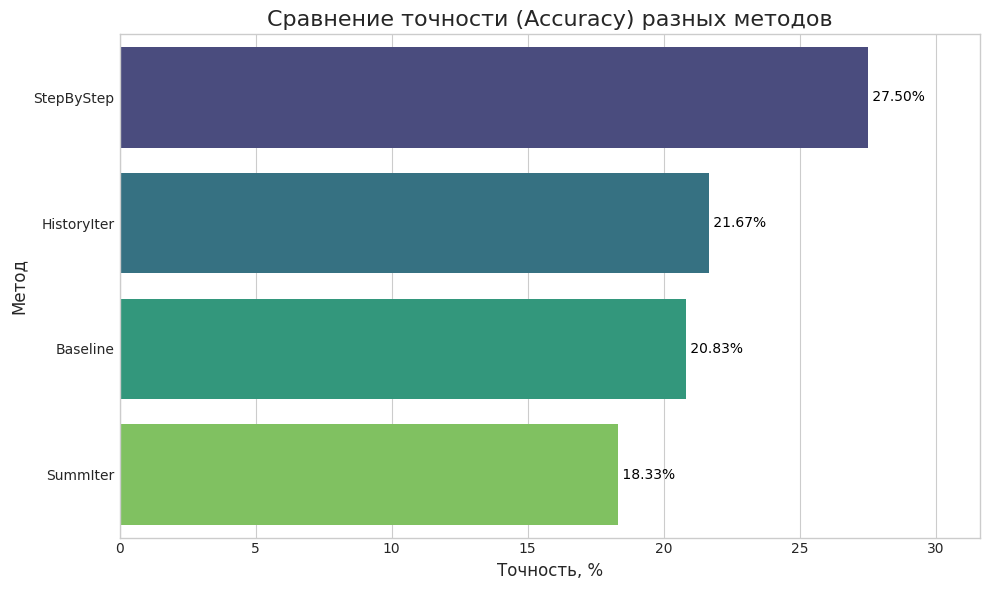

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# --- 1. Загрузка и объединение данных ---

# Словарь с именами экспериментов и путями к файлам
# Мы возьмем "короткие" имена для удобства в таблицах и на графиках
experiments = {
    'Baseline': 'experiment_results_baseline.csv', # Предполагаем, что baseline - это CoT
    'HistoryIter': 'experiment_results_iterhistory.csv',
    'StepByStep': 'experiment_results_stepbystep.csv', # Возможно, это тот же CoT, но лучше разделить
    'SummIter': 'experiment_results_summarization.csv'
}

# Загружаем каждый CSV и выбираем только нужные колонки
data_frames = []
for name, path in experiments.items():
    try:
        df = pd.read_csv(path)
        # Для каждого фрейма переименовываем колонку is_correct, чтобы она была уникальной
        # и выбираем только ее и вопрос для объединения
        df_subset = df[['original_question', 'is_correct', 'reasoning_steps_text']].rename(columns={
            'is_correct': f'correct_{name}',
            'reasoning_steps_text': f'reasoning_{name}'
        })
        data_frames.append(df_subset)
    except FileNotFoundError:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Файл {path} не найден. Пропускаем этот эксперимент.")

# Объединяем все DataFrame в один по колонке 'original_question'
if not data_frames:
    print("Ошибка: не найдено ни одного файла с результатами. Завершение работы.")
else:
    # Используем functools.reduce для последовательного мержа всех датафреймов
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='original_question', how='outer'), data_frames)
    # Заполним пропуски (если какой-то вопрос не был обработан в одном из экспериментов)
    for col in merged_df.columns:
        if 'correct_' in col:
            merged_df[col] = merged_df[col].fillna(False) # Считаем пропуск как ошибку

    print("✅ Данные из всех экспериментов успешно загружены и объединены.")
    print(f"Всего уникальных задач для анализа: {len(merged_df)}")


    # --- 2. Расчет и вывод общей статистики ---
    
    summary = []
    correct_cols = [col for col in merged_df.columns if 'correct_' in col]

    for col in correct_cols:
        exp_name = col.replace('correct_', '')
        correct_count = merged_df[col].sum()
        total_count = len(merged_df)
        accuracy = (correct_count / total_count) * 100
        summary.append({
            'Experiment': exp_name,
            'Correct Answers': correct_count,
            'Total': total_count,
            'Accuracy (%)': accuracy
        })

    summary_df = pd.DataFrame(summary).sort_values(by='Accuracy (%)', ascending=False)

    print("\n\n--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ ---")
    print(summary_df.to_string(index=False))


    # --- 3. Визуализация точности ---
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    
    barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette='viridis')
    
    # Добавляем значения на сам график
    for index, value in enumerate(summary_df['Accuracy (%)']):
        barplot.text(value, index, f' {value:.2f}%', color='black', ha="left", va='center')

    plt.title('Сравнение точности (Accuracy) разных методов', fontsize=16)
    plt.xlabel('Точность, %', fontsize=12)
    plt.ylabel('Метод', fontsize=12)
    plt.xlim(0, max(summary_df['Accuracy (%)']) * 1.15) # Оставляем место для текста
    plt.tight_layout()
    plt.savefig("accuracy_comparison.png")
    print("\n✅ График сравнения точности сохранен в файл 'accuracy_comparison.png'")
    plt.show()


    # --- 4. Анализ пересечения ошибок ---

    # Создадим "сигнатуру" успеха/неудачи для каждой задачи
    # Например: B-T, I-T, S-F, Z-F (Baseline-True, IterHistory-True, Step-False, Summarization-False)
    def create_signature(row):
        parts = []
        for col in correct_cols:
            exp_name_short = col.replace('correct_', '')[:1] # Первая буква имени
            status = "✅" if row[col] else "❌"
            parts.append(f"{exp_name_short}:{status}")
        return " | ".join(parts)

    merged_df['signature'] = merged_df.apply(create_signature, axis=1)
    
    signature_counts = merged_df['signature'].value_counts().reset_index()
    signature_counts.columns = ['Pattern (✅=Correct, ❌=Fail)', 'Number of Questions']

In [7]:
import pandas as pd

# --- ПРЕДПОСЫЛКА ---
# Убедитесь, что DataFrame 'merged_df' из предыдущего скрипта анализа существует.
# Если нет, сначала выполните код из analyze_results.py для его создания.

# Проверяем, существует ли merged_df, чтобы избежать ошибок
if 'merged_df' not in locals():
    print("Ошибка: DataFrame 'merged_df' не найден.")
    print("Пожалуйста, сначала запустите код из скрипта 'analyze_results.py' для загрузки и объединения данных.")
else:
    # 1. Определяем колонки, по которым будем группировать (все, что содержат 'correct_')
    correct_cols = [col for col in merged_df.columns if col.startswith('correct_')]

    # 2. Группируем по уникальным паттернам True/False и считаем количество задач в каждой группе
    pattern_counts = merged_df.groupby(correct_cols).size().reset_index(name='Количество задач')

    # 3. Сортируем по количеству задач (от самых частых паттернов к редким)
    pattern_counts = pattern_counts.sort_values(by='Количество задач', ascending=False)

    # 4. Создаем словарь для переименования колонок (убираем префикс 'correct_')
    # Пример: 'correct_Baseline (CoT)' -> 'Baseline (CoT)'
    rename_map = {col: col.replace('correct_', '') for col in correct_cols}

    # 5. Переименовываем колонки в нашем новом DataFrame
    pattern_counts = pattern_counts.rename(columns=rename_map)
    
    # 6. Заменяем булевы значения (True/False) на эмодзи для наглядности
    # Получаем новые имена колонок после переименования
    renamed_cols = list(rename_map.values())
    for col in renamed_cols:
        pattern_counts[col] = pattern_counts[col].replace({True: '✅', False: '❌'})

    # 7. Сбрасываем индекс для красивого вывода
    final_df = pattern_counts.reset_index(drop=True)

    # --- ВЫВОД РЕЗУЛЬТАТА ---
    print("DataFrame с распределением результатов по задачам:")
    
    # Используем display() для красивого вывода в Jupyter/Colab
    # Если вы не в ноутбуке, используйте print(final_df)
    display(final_df)

DataFrame с распределением результатов по задачам:


,Baseline,HistoryIter,StepByStep,SummIter,Количество задач
0,❌,❌,❌,❌,58
1,❌,✅,❌,❌,11
2,❌,❌,✅,❌,10
3,✅,❌,✅,❌,8
4,✅,❌,❌,❌,7
5,❌,❌,❌,✅,6
6,❌,✅,✅,✅,4
7,✅,✅,✅,❌,3
8,✅,✅,✅,✅,3
9,❌,✅,❌,✅,3


In [9]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging # <-- НОВОЕ: Импортируем библиотеку для логирования

# <-- НОВОЕ: Подавляем лишние предупреждения от transformers.
# Устанавливаем уровень логирования на ERROR, чтобы видеть только ошибки.
logging.getLogger("transformers").setLevel(logging.ERROR)


# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- НОВЫЙ ШАГ 3: Функции для итеративного решения с СУММАРИЗАЦИЕЙ и ЛОГИРОВАНИЕМ ---

def summarize_history_batch(questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку текущего состояния решения задачи для пакета.
    """
    summarization_template = """Original Question: {question}
Reasoning so far:
{history}

---
Summarize the current state of the problem based on the reasoning. What has been calculated? What is the immediate next goal? Be very brief and concise.
Current Summary:"""
    
    prompts = [summarization_template.format(question=q, history=h) for q, h in zip(questions, histories)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=80, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )
    
    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

def solve_batch_with_iterative_summarization(questions_batch: list[str]) -> tuple[list[str], list[str]]:
    """
    Решает ПАКЕТ задач, итеративно генерируя шаги, СУММАРИЗИРУЯ контекст и ВОЗВРАЩАЯ ДЕТАЛЬНЫЕ ЛОГИ.
    """
    batch_size = len(questions_batch)
    
    initial_prompt_template = "Solve this math problem step-by-step. Use ONLY given information.\nQuestion: {question}\nWhat is the very first step?\nStep 1:"
    iterative_template_with_summary = "Continue solving this math problem. Based on the summary of progress, perform the single next calculation step.\nOriginal Question: {question}\nSummary of Progress:\n{summary}\n\nWhat is the single next step? If you have the final answer, state it clearly and end with #### <answer>.\nNext Step:"

    full_histories = [""] * batch_size
    summarized_contexts = ["Initial state: No steps taken yet."] * batch_size
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))
    
    detailed_logs = ["" for _ in range(batch_size)]
    for i in range(batch_size):
        detailed_logs[i] += f"--- INITIAL PROMPT ---\n{current_prompts[i]}\n\n"

    for step_num in range(MAX_STEPS):
        if not active_indices: break

        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=80, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]
        
        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            detailed_logs[original_index] += f"--- MODEL RESPONSE (STEP {step_num + 1}) ---\n{new_step}\n\n"

        indices_that_need_summarizing = []
        histories_to_summarize = []
        questions_to_summarize = []
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            if "####" in new_step:
                final_solutions[original_index] = full_histories[original_index]
            else:
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        if indices_that_need_summarizing:
            new_summaries = summarize_history_batch(questions_to_summarize, histories_to_summarize)
            
            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        for original_index in remaining_indices_for_next_step:
            current_prompts[original_index] = iterative_template_with_summary.format(
                question=questions_batch[original_index], 
                summary=summarized_contexts[original_index]
            )
            detailed_logs[original_index] += f"--- NEXT PROMPT (FOR STEP {step_num + 2}) ---\n{current_prompts[original_index]}\n\n"

        active_indices = remaining_indices_for_next_step

    for i in active_indices:
        final_solutions[i] = full_histories[i]
        
    return [s.strip() for s in final_solutions], detailed_logs


# --- Шаг 4: Основной цикл оценки с логированием в DataFrame ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")

results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах с итеративной суммаризацией...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    generated_solutions, detailed_batch_logs = solve_batch_with_iterative_summarization(batch_questions)

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)

        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct,
            "detailed_log": detailed_batch_logs[j]
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame ---
results_df = pd.DataFrame(results_log)

print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.drop(columns=['detailed_log']).head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_summarization_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

# --- НОВЫЙ ШАГ 6: Запись примеров в текстовый файл ---

try:
    correct_example = results_df[results_df['is_correct'] == True].iloc[0]
    has_correct = True
except IndexError:
    has_correct = False
    print("Предупреждение: не найдено ни одного правильно решенного примера.")

try:
    incorrect_example = results_df[results_df['is_correct'] == False].iloc[0]
    has_incorrect = True
except IndexError:
    has_incorrect = False
    print("Предупреждение: не найдено ни одного неправильно решенного примера.")

log_filename = f"summarization_deep_dive_{timestamp}.txt"
with open(log_filename, "w", encoding="utf-8") as f:
    f.write("="*40 + " АНАЛИЗ РАБОТЫ МЕТОДА СУММАРИЗАЦИИ " + "="*40 + "\n\n")

    if has_correct:
        f.write("="*30 + " ПРИМЕР ПРАВИЛЬНО РЕШЕННОЙ ЗАДАЧИ " + "="*30 + "\n\n")
        f.write(f"ВОПРОС: {correct_example['original_question']}\n\n")
        f.write(f"ПРАВИЛЬНЫЙ ОТВЕТ (из датасета): {correct_example['original_answer_text']}\n\n")
        f.write(f"ПРЕДСКАЗАННЫЙ ОТВЕТ: {correct_example['predicted_answer']}\n\n")
        f.write("-" * 20 + " ДЕТАЛЬНЫЙ ЛОГ ПРОЦЕССА РЕШЕНИЯ " + "-" * 20 + "\n\n")
        f.write(correct_example['detailed_log'])
        f.write("\n\n")

    if has_incorrect:
        f.write("="*30 + " ПРИМЕР НЕПРАВИЛЬНО РЕШЕННОЙ ЗАДАЧИ " + "="*30 + "\n\n")
        f.write(f"ВОПРОС: {incorrect_example['original_question']}\n\n")
        f.write(f"ПРАВИЛЬНЫЙ ОТВЕТ (из датасета): {incorrect_example['original_answer_text']}\n\n")
        f.write(f"ПРЕДСКАЗАННЫЙ ОТВЕТ: {incorrect_example['predicted_answer']}\n\n")
        f.write("-" * 20 + " ДЕТАЛЬНЫЙ ЛОГ ПРОЦЕССА РЕШЕНИЯ " + "-" * 20 + "\n\n")
        f.write(incorrect_example['detailed_log'])
        f.write("\n\n")

if has_correct or has_incorrect:
    print(f"✅ Детальный анализ примеров сохранен в файл: {log_filename}")


# --- Итоговая статистика (без изменений) ---
correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)

if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: Qwen/Qwen2-1.5B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах с итеративной суммаризацией...


Evaluating Batches: 100%|██████████| 15/15 [28:57<00:00, 115.84s/it]


--- Пример собранных данных (первые 5 строк) ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                         original_question  \
0                                                                                                                                                                                                 Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' marke

In [10]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging

# Подавляем лишние предупреждения от transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- УЛУЧШЕННЫЙ ШАГ 3: Функции для итеративного решения с ГИБРИДНЫМ КОНТЕКСТОМ ---

def summarize_for_hybrid_context(questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку, делая акцент на числах и следующей цели.
    """
    # УЛУЧШЕННЫЙ ПРОМПТ: Просим явно перечислить известные значения.
    summarization_template = """Original Question: {question}
Reasoning History:
{history}
---
Based on the history, provide a summary.
1.  **Known Values:** List all key numerical values from the original question and calculations so far.
2.  **Next Goal:** State the immediate next objective.
Be brief and precise.

Summary:"""
    
    prompts = [summarization_template.format(question=q, history=h) for q, h in zip(questions, histories)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1536).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=100, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )
    
    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

def solve_batch_with_hybrid_context(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, используя ГИБРИДНЫЙ контекст (сводка + полная история).
    """
    batch_size = len(questions_batch)

    # Определяем шаблоны промптов
    initial_prompt_template = """Solve this math problem step-by-step.
Question: {question}
Let's think step by step.
Step 1:"""
    
    # УЛУЧШЕННЫЙ ИТЕРАТИВНЫЙ ПРОМПТ: Использует и сводку, и историю
    hybrid_iterative_template = """You are solving a math problem. Use the summary for focus and the full history for reference.
Original Question: {question}

Summary of Progress:
{summary}

Full History of Steps:
{history}
---
Based on the summary and referencing the full history, perform the single next calculation step. If you have the final answer, state it clearly and end with #### <answer>.
Next Step:"""

    # Инициализируем состояния
    full_histories = [""] * batch_size
    summarized_contexts = ["No summary yet."] * batch_size
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices: break

        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=120, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]
        
        indices_that_need_summarizing = []
        histories_to_summarize = []
        questions_to_summarize = []
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            if "####" in new_step:
                final_solutions[original_index] = full_histories[original_index]
            else:
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        if indices_that_need_summarizing:
            new_summaries = summarize_for_hybrid_context(questions_to_summarize, histories_to_summarize)
            
            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        for original_index in remaining_indices_for_next_step:
            current_prompts[original_index] = hybrid_iterative_template.format(
                question=questions_batch[original_index], 
                summary=summarized_contexts[original_index],
                history=full_histories[original_index].strip() # <-- ГЛАВНОЕ ИЗМЕНЕНИЕ
            )

        active_indices = remaining_indices_for_next_step

    for i in active_indices:
        final_solutions[i] = full_histories[i]
        
    return [s.strip() for s in final_solutions]


# --- Шаг 4: Основной цикл оценки (вызывает новую функцию) ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")
results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах с УЛУЧШЕННЫМ гибридным контекстом...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    # Вызываем новую, улучшенную функцию
    generated_solutions = solve_batch_with_hybrid_context(batch_questions)

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)
        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame ---
results_df = pd.DataFrame(results_log)
print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_hybrid_summarization_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: Qwen/Qwen2-1.5B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах с УЛУЧШЕННЫМ гибридным контекстом...


Evaluating Batches: 100%|██████████| 15/15 [34:18<00:00, 137.23s/it]


--- Пример собранных данных (первые 5 строк) ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                         original_question  \
0                                                                                                                                                                                                 Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' marke

In [11]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging

# Подавляем лишние предупреждения от transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8
# Новые константы для токенов
MAX_TOKENS_FOR_PLAN = 150
MAX_TOKENS_FOR_SOLUTION = 350


# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- НОВЫЙ ШАГ 3: Функции для подхода "Plan-and-Solve" ---

def generate_plan_batch(questions_batch: list[str]) -> list[str]:
    """
    ЭТАП 1: ГЕНЕРАЦИЯ ПЛАНА. Модель создает высокоуровневый план без вычислений.
    """
    # Промпт для "Планировщика"
    planner_template = """Given a math problem, create a step-by-step plan to solve it.
DO NOT perform any calculations or find the final answer.
Just list the logical steps you would take.

Problem: {question}

Plan:"""
    
    prompts = [planner_template.format(question=q) for q in questions_batch]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_TOKENS_FOR_PLAN,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            num_beams=1
        )
    
    plans = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return plans

def solve_batch_with_plan_and_solve(questions_batch: list[str]) -> list[str]:
    """
    Основная функция: сначала генерирует планы, затем решает задачи по этим планам.
    """
    # Этап 1: Получаем планы для всего батча
    plans_batch = generate_plan_batch(questions_batch)
    
    # Этап 2: Решаем задачи, используя полученные планы
    
    # Промпт для "Исполнителя"
    solver_template = """Here is a math problem and a plan to solve it.
Follow the plan step-by-step, showing all your calculations.
End your final response with: #### <answer>.

Problem: {question}

Plan:
{plan}
---
Now, execute the plan step-by-step. Show your work.
Solution:"""

    prompts = [solver_template.format(question=q, plan=p) for q, p in zip(questions_batch, plans_batch)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_TOKENS_FOR_SOLUTION,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
            num_beams=1
        )

    solutions = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return solutions


# --- Шаг 4: Основной цикл оценки (вызывает новую функцию) ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")
results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах с подходом 'Plan-and-Solve'...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    # Вызываем новую функцию
    generated_solutions = solve_batch_with_plan_and_solve(batch_questions)

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)
        # Здесь "количество шагов" - это просто количество строк в финальном решении
        num_steps = len(generated_solution_text.split('\n'))

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame ---
results_df = pd.DataFrame(results_log)
print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_plan_and_solve_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: Qwen/Qwen2-1.5B-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах с подходом 'Plan-and-Solve'...


Evaluating Batches: 100%|██████████| 15/15 [11:11<00:00, 44.76s/it]


--- Пример собранных данных (первые 5 строк) ---
                                                                                                                                                                                                                                                                                                                                                                                                                                                                         original_question  \
0                                                                                                                                                                                                 Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' marke

✅ Данные из всех экспериментов успешно загружены и объединены.
Всего уникальных задач для анализа: 120


--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ (в заданном порядке) ---
  Experiment  Correct Answers  Total  Accuracy (%)
  IterHybrid               39    120     32.500000
PlanAndSolve               37    120     30.833333
  StepByStep               33    120     27.500000
 IterHistory               26    120     21.666667
    Baseline               25    120     20.833333
    IterSumm               22    120     18.333333


/tmp/ipykernel_1505368/414417664.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette='viridis', ax=ax)



✅ Финальный график с заданным порядком сохранен в файл 'accuracy_comparison_custom_order.png'


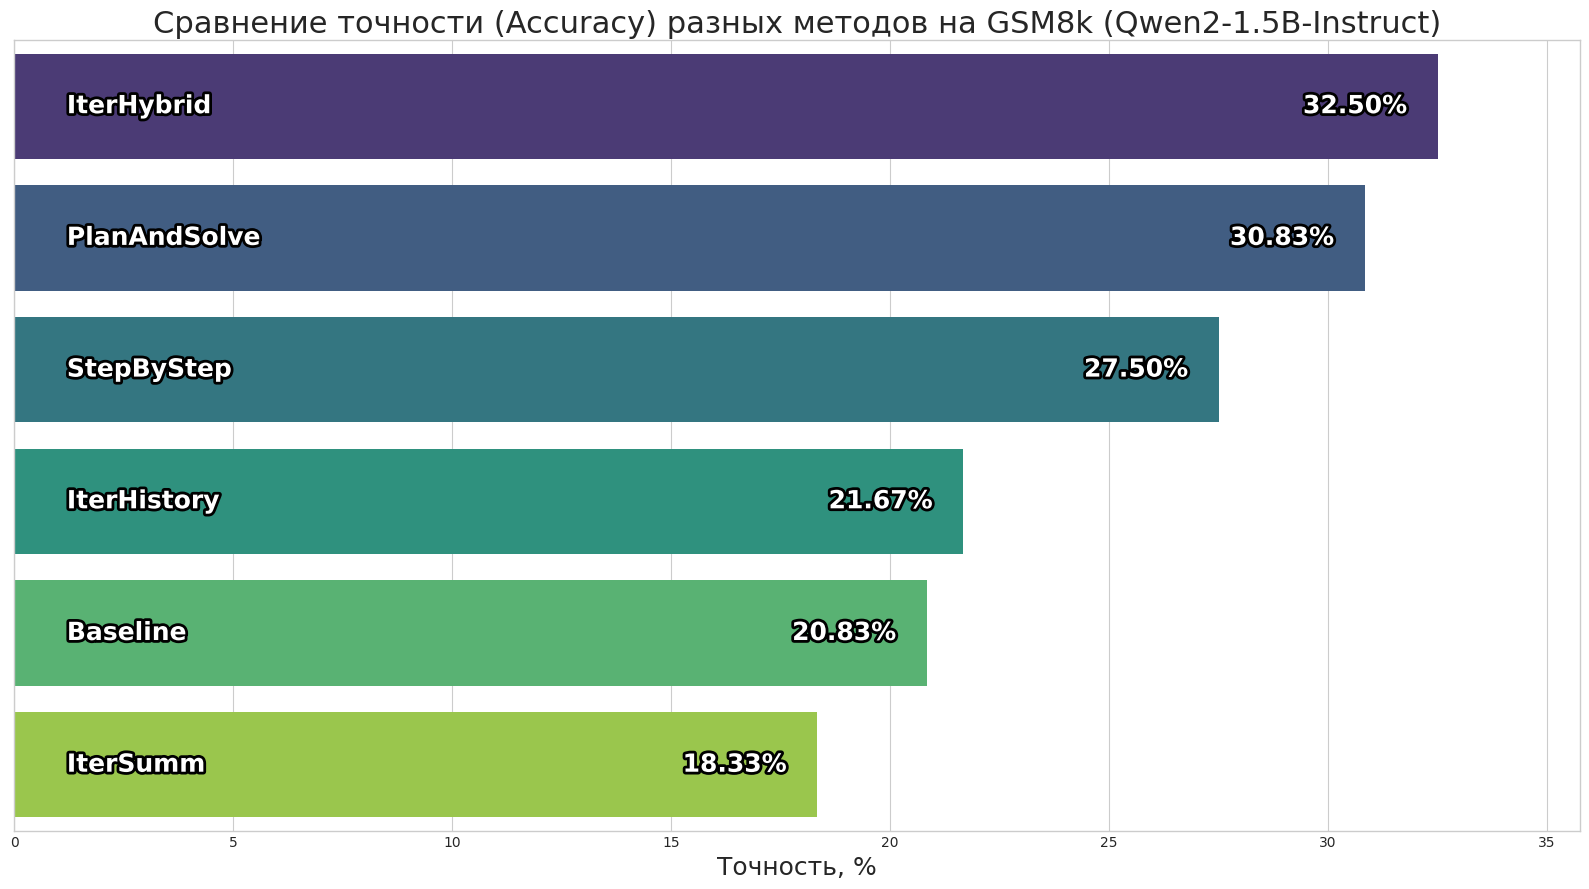



--- РАСПРЕДЕЛЕНИЕ РЕЗУЛЬТАТОВ ПО ЗАДАЧАМ ---
Показывает, сколько задач соответствуют каждому паттерну успеха/неудачи.
                            Pattern (✅=Correct, ❌=Fail)  Number of Questions
0   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                   43
1   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:✅ | Step:❌                    7
2   Base:❌ | Iter:❌ | Iter:✅ | Iter:❌ | Plan:❌ | Step:❌                    6
3   Base:❌ | Iter:✅ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                    5
4   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:✅                    5
5   Base:✅ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                    4
6   Base:❌ | Iter:❌ | Iter:❌ | Iter:✅ | Plan:❌ | Step:❌                    4
7   Base:✅ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:✅ | Step:✅                    3
8   Base:❌ | Iter:✅ | Iter:✅ | Iter:✅ | Plan:✅ | Step:✅                    3
9   Base:❌ | Iter:✅ | Iter:✅ | Iter:❌ | Plan:✅ | Step:❌                    3
10  Base:✅ | Iter:✅ | Iter:✅ | It

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import matplotlib.patheffects as path_effects # Импорт для эффектов текста

# --- 1. Загрузка и объединение данных ---

experiments = {
    'Baseline': 'experiment_results_baseline.csv',
    'IterHistory': 'experiment_results_iterhistory.csv',
    'StepByStep': 'experiment_results_stepbystep.csv',
    'IterSumm': 'experiment_results_summarization.csv',
    'IterHybrid': 'experiment_results_hybryditer.csv',
    'PlanAndSolve': 'experiment_results_planandsolve.csv'
}

data_frames = []
for name, path in experiments.items():
    try:
        df = pd.read_csv(path)
        df_subset = df[['original_question', 'is_correct', 'reasoning_steps_text']].rename(columns={
            'is_correct': f'correct_{name}',
            'reasoning_steps_text': f'reasoning_{name}'
        })
        data_frames.append(df_subset)
    except FileNotFoundError:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Файл '{path}' не найден. Пропускаем эксперимент '{name}'.")

if not data_frames:
    print("Ошибка: не найдено ни одного файла с результатами. Завершение работы.")
else:
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='original_question', how='outer'), data_frames)
    for col in merged_df.columns:
        if 'correct_' in col:
            merged_df[col] = merged_df[col].fillna(False)

    print("✅ Данные из всех экспериментов успешно загружены и объединены.")
    print(f"Всего уникальных задач для анализа: {len(merged_df)}")


    # --- 2. Расчет, ВЫВОД СТАТИСТИКИ И КАСТОМНАЯ СОРТИРОВКА ---
    
    summary = []
    correct_cols = [col for col in merged_df.columns if col.startswith('correct_')]

    for col in correct_cols:
        exp_name = col.replace('correct_', '')
        correct_count = merged_df[col].sum()
        total_count = len(merged_df)
        accuracy = (correct_count / total_count) * 100
        summary.append({
            'Experiment': exp_name,
            'Correct Answers': int(correct_count),
            'Total': total_count,
            'Accuracy (%)': accuracy
        })

    summary_df = pd.DataFrame(summary)

    # <-- ВОТ ГЛАВНОЕ ИЗМЕНЕНИЕ: ЗАДАЕМ КАСТОМНЫЙ ПОРЯДОК
    # 1. Определяем порядок, как на вашем изображении
    custom_order = [
        'IterHybrid',
        'PlanAndSolve',
        'StepByStep',
        'IterHistory',
        'Baseline',
        'IterSumm'
    ]

    # 2. Превращаем колонку 'Experiment' в категорию с заданным порядком
    summary_df['Experiment'] = pd.Categorical(summary_df['Experiment'], categories=custom_order, ordered=True)
    
    # 3. Сортируем DataFrame в соответствии с этим новым порядком
    summary_df = summary_df.sort_values('Experiment')
    
    print("\n\n--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ (в заданном порядке) ---")
    print(summary_df.to_string(index=False))


    # --- 3. Визуализация точности (без изменений, т.к. DataFrame уже отсортирован) ---
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 9))

    barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette='viridis', ax=ax)

    text_effect = [path_effects.Stroke(linewidth=4, foreground='black'), path_effects.Normal()]

    for index, row in summary_df.iterrows():
        exp_name = row['Experiment']
        accuracy_val = row['Accuracy (%)']
        
        # Индекс для barplot нужно брать из числового ряда, а не из индекса DataFrame
        plot_index = list(summary_df.index).index(index)
        
        ax.text(1, plot_index, f' {exp_name}', color='white', ha='left', va='center', fontsize=18, fontweight='bold', path_effects=text_effect)
        ax.text(accuracy_val - 0.5, plot_index, f'{accuracy_val:.2f}% ', color='white', ha='right', va='center', fontsize=18, fontweight='bold', path_effects=text_effect)

    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_title('Сравнение точности (Accuracy) разных методов на GSM8k (Qwen2-1.5B-Instruct)', fontsize=22)
    ax.set_xlabel('Точность, %', fontsize=18)
    ax.set_xlim(0, max(summary_df['Accuracy (%)']) * 1.1)
    
    plt.tight_layout()
    
    output_filename_plot = "accuracy_comparison_custom_order.png"
    plt.savefig(output_filename_plot, dpi=200)
    print(f"\n✅ Финальный график с заданным порядком сохранен в файл '{output_filename_plot}'")
    plt.show()


    # --- 4. Анализ пересечения ошибок ---

    def create_signature(row):
        parts = []
        for col in sorted(correct_cols):
            exp_name_short = col.replace('correct_', '')[:4] 
            status = "✅" if row[col] else "❌"
            parts.append(f"{exp_name_short}:{status}")
        return " | ".join(parts)

    merged_df['signature'] = merged_df.apply(create_signature, axis=1)
    
    signature_counts = merged_df['signature'].value_counts().reset_index()
    signature_counts.columns = ['Pattern (✅=Correct, ❌=Fail)', 'Number of Questions']
    
    print("\n\n--- РАСПРЕДЕЛЕНИЕ РЕЗУЛЬТАТОВ ПО ЗАДАЧАМ ---")
    print("Показывает, сколько задач соответствуют каждому паттерну успеха/неудачи.")
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(signature_counts)

✅ Данные из всех экспериментов успешно загружены и объединены.
Всего уникальных задач для анализа: 120


--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ (в заданном порядке) ---
  Experiment  Correct Answers  Total  Accuracy (%)
  IterHybrid               39    120     32.500000
PlanAndSolve               37    120     30.833333
  StepByStep               33    120     27.500000
 IterHistory               26    120     21.666667
    Baseline               25    120     20.833333
    IterSumm               22    120     18.333333


/tmp/ipykernel_1505368/3867267868.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette='viridis', ax=ax)



✅ Финальный график с очень крупным шрифтом сохранен в файл 'accuracy_comparison_largest_font.png'


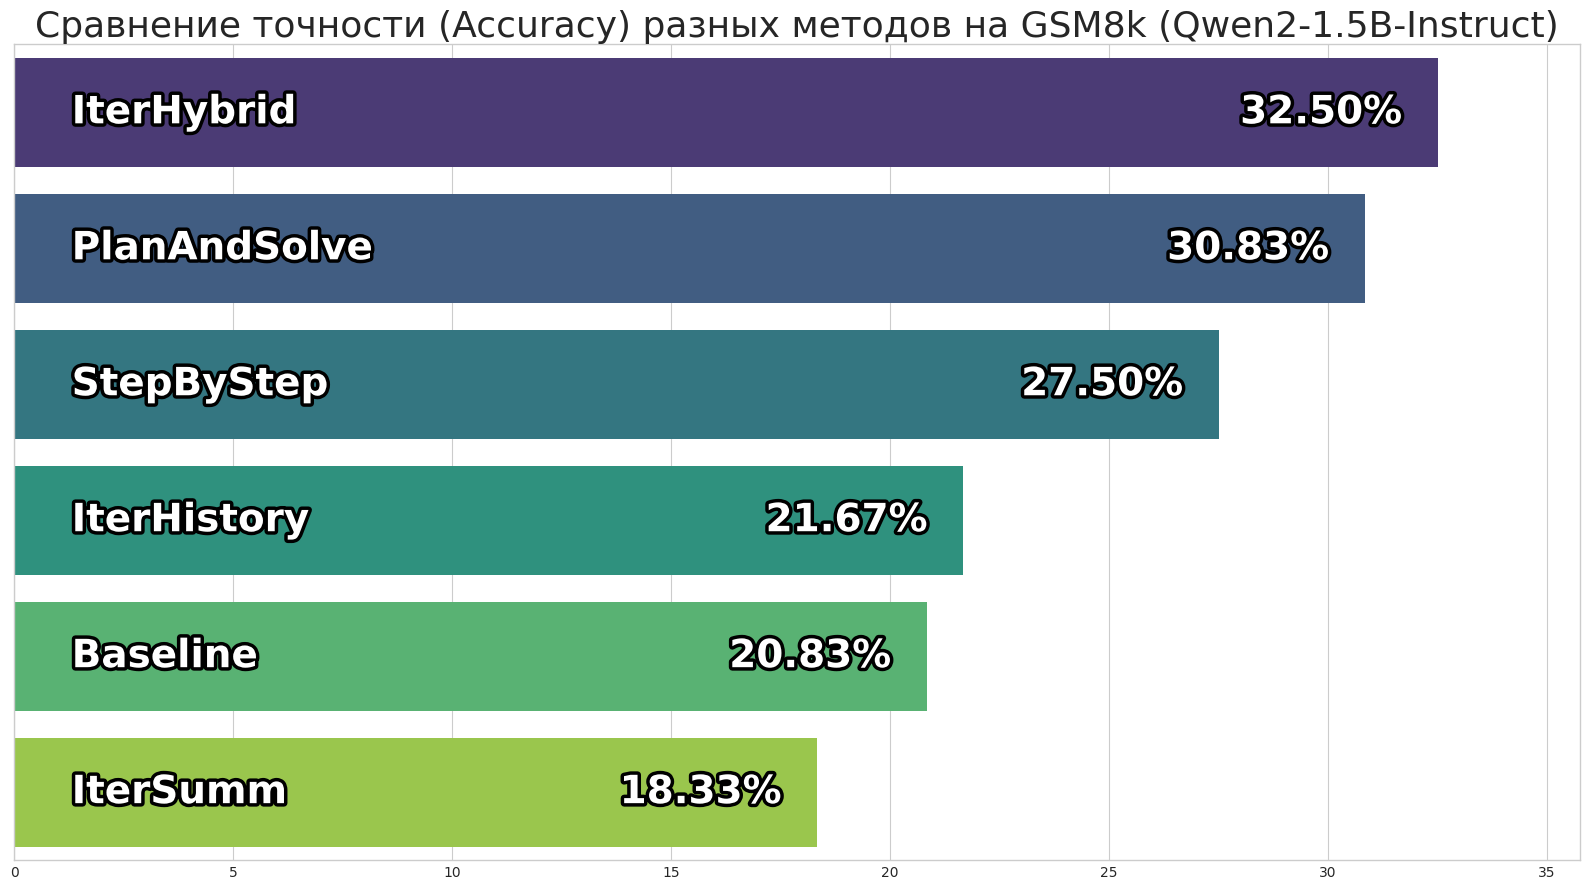



--- РАСПРЕДЕЛЕНИЕ РЕЗУЛЬТАТОВ ПО ЗАДАЧАМ ---
Показывает, сколько задач соответствуют каждому паттерну успеха/неудачи.
                            Pattern (✅=Correct, ❌=Fail)  Number of Questions
0   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                   43
1   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:✅ | Step:❌                    7
2   Base:❌ | Iter:❌ | Iter:✅ | Iter:❌ | Plan:❌ | Step:❌                    6
3   Base:❌ | Iter:✅ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                    5
4   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:✅                    5
5   Base:✅ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                    4
6   Base:❌ | Iter:❌ | Iter:❌ | Iter:✅ | Plan:❌ | Step:❌                    4
7   Base:✅ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:✅ | Step:✅                    3
8   Base:❌ | Iter:✅ | Iter:✅ | Iter:✅ | Plan:✅ | Step:✅                    3
9   Base:❌ | Iter:✅ | Iter:✅ | Iter:❌ | Plan:✅ | Step:❌                    3
10  Base:✅ | Iter:✅ | Iter:✅ | It

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import matplotlib.patheffects as path_effects # Импорт для эффектов текста

# --- 1. Загрузка и объединение данных ---

experiments = {
    'Baseline': 'experiment_results_baseline.csv',
    'IterHistory': 'experiment_results_iterhistory.csv',
    'StepByStep': 'experiment_results_stepbystep.csv',
    'IterSumm': 'experiment_results_summarization.csv',
    'IterHybrid': 'experiment_results_hybryditer.csv',
    'PlanAndSolve': 'experiment_results_planandsolve.csv'
}

data_frames = []
for name, path in experiments.items():
    try:
        df = pd.read_csv(path)
        df_subset = df[['original_question', 'is_correct', 'reasoning_steps_text']].rename(columns={
            'is_correct': f'correct_{name}',
            'reasoning_steps_text': f'reasoning_{name}'
        })
        data_frames.append(df_subset)
    except FileNotFoundError:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Файл '{path}' не найден. Пропускаем эксперимент '{name}'.")

if not data_frames:
    print("Ошибка: не найдено ни одного файла с результатами. Завершение работы.")
else:
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='original_question', how='outer'), data_frames)
    for col in merged_df.columns:
        if 'correct_' in col:
            merged_df[col] = merged_df[col].fillna(False)

    print("✅ Данные из всех экспериментов успешно загружены и объединены.")
    print(f"Всего уникальных задач для анализа: {len(merged_df)}")


    # --- 2. Расчет, ВЫВОД СТАТИСТИКИ И КАСТОМНАЯ СОРТИРОВКА ---
    
    summary = []
    correct_cols = [col for col in merged_df.columns if col.startswith('correct_')]

    for col in correct_cols:
        exp_name = col.replace('correct_', '')
        correct_count = merged_df[col].sum()
        total_count = len(merged_df)
        accuracy = (correct_count / total_count) * 100
        summary.append({
            'Experiment': exp_name,
            'Correct Answers': int(correct_count),
            'Total': total_count,
            'Accuracy (%)': accuracy
        })

    summary_df = pd.DataFrame(summary)

    custom_order = [
        'IterHybrid',
        'PlanAndSolve',
        'StepByStep',
        'IterHistory',
        'Baseline',
        'IterSumm'
    ]

    summary_df['Experiment'] = pd.Categorical(summary_df['Experiment'], categories=custom_order, ordered=True)
    summary_df = summary_df.sort_values('Experiment')
    
    print("\n\n--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ (в заданном порядке) ---")
    print(summary_df.to_string(index=False))


    # --- 3. Визуализация точности (САМАЯ НОВАЯ ВЕРСИЯ) ---
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 9))

    barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette='viridis', ax=ax)

    # Увеличиваем толщину обводки для нового размера шрифта
    text_effect = [path_effects.Stroke(linewidth=5, foreground='black'), path_effects.Normal()]

    for index, row in summary_df.iterrows():
        exp_name = row['Experiment']
        accuracy_val = row['Accuracy (%)']
        plot_index = list(summary_df.index).index(index)
        
        # Увеличиваем fontsize до 22
        ax.text(1, plot_index, f' {exp_name}', color='white', ha='left', va='center', fontsize=28, fontweight='bold', path_effects=text_effect)
        ax.text(accuracy_val - 0.5, plot_index, f'{accuracy_val:.2f}% ', color='white', ha='right', va='center', fontsize=28, fontweight='bold', path_effects=text_effect)

    # Убираем подписи на осях Y и X
    ax.set_ylabel('')
    ax.set_xlabel('') # <--- УБИРАЕМ ПОДПИСЬ ОСИ X
    
    # Отключаем метки (названия методов) на оси Y
    ax.set_yticks([])

    # Увеличиваем шрифт заголовка
    ax.set_title('Сравнение точности (Accuracy) разных методов на GSM8k (Qwen2-1.5B-Instruct)', fontsize=26)
    
    ax.set_xlim(0, max(summary_df['Accuracy (%)']) * 1.1)
    
    plt.tight_layout()
    
    output_filename_plot = "accuracy_comparison_largest_font.png"
    plt.savefig(output_filename_plot, dpi=200)
    print(f"\n✅ Финальный график с очень крупным шрифтом сохранен в файл '{output_filename_plot}'")
    plt.show()


    # --- 4. Анализ пересечения ошибок ---

    def create_signature(row):
        parts = []
        for col in sorted(correct_cols):
            exp_name_short = col.replace('correct_', '')[:4] 
            status = "✅" if row[col] else "❌"
            parts.append(f"{exp_name_short}:{status}")
        return " | ".join(parts)

    merged_df['signature'] = merged_df.apply(create_signature, axis=1)
    
    signature_counts = merged_df['signature'].value_counts().reset_index()
    signature_counts.columns = ['Pattern (✅=Correct, ❌=Fail)', 'Number of Questions']
    
    print("\n\n--- РАСПРЕДЕЛЕНИЕ РЕЗУЛЬТАТОВ ПО ЗАДАЧАМ ---")
    print("Показывает, сколько задач соответствуют каждому паттерну успеха/неудачи.")
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(signature_counts)

✅ Данные из всех экспериментов успешно загружены и объединены.
Всего уникальных задач для анализа: 120


--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ (в заданном порядке) ---
        Experiment  Correct Answers  Total  Accuracy (%)
 IterHybrid (ours)               39    120     32.500000
      PlanAndSolve               37    120     30.833333
        StepByStep               33    120     27.500000
IterHistory (ours)               26    120     21.666667
          Baseline               25    120     20.833333
   IterSumm (ours)               22    120     18.333333


/tmp/ipykernel_1555473/1767954815.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette=custom_palette, ax=ax)



✅ Финальный график с синим цветом в палитре сохранен в файл 'accuracy_comparison_with_blue_bar.png'


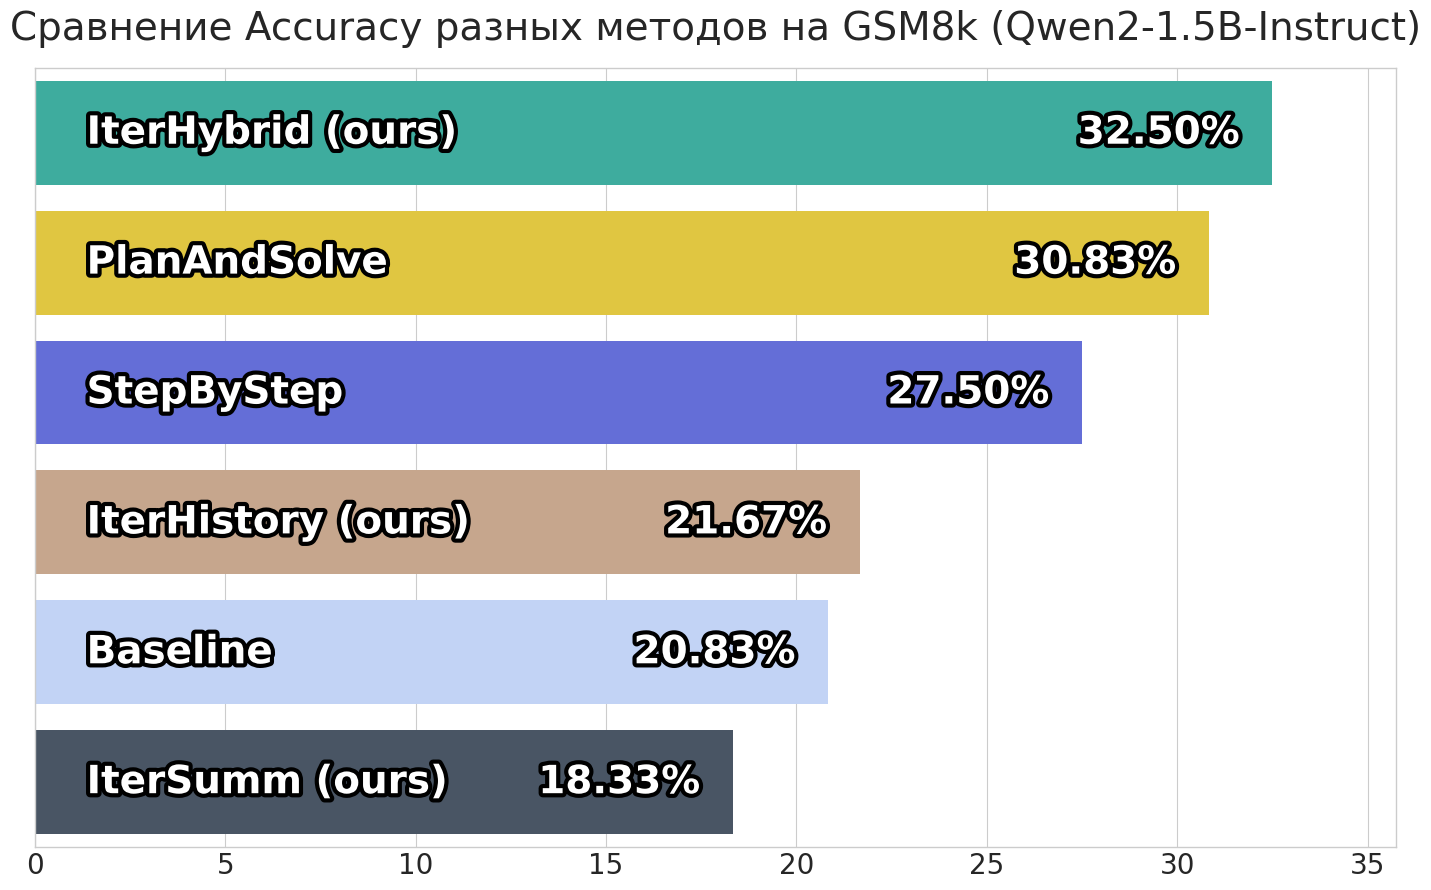



--- РАСПРЕДЕЛЕНИЕ РЕЗУЛЬТАТОВ ПО ЗАДАЧАМ ---
Показывает, сколько задач соответствуют каждому паттерну успеха/неудачи.
                          Pattern (✅=Correct, ❌=Fail)  Number of Questions
0   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | S...                   43
1   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:✅ | S...                    7
2   Base:❌ | Iter:❌ | Iter:✅ | Iter:❌ | Plan:❌ | S...                    6
3   Base:❌ | Iter:✅ | Iter:❌ | Iter:❌ | Plan:❌ | S...                    5
4   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | S...                    5
5   Base:✅ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | S...                    4
6   Base:❌ | Iter:❌ | Iter:❌ | Iter:✅ | Plan:❌ | S...                    4
7   Base:✅ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:✅ | S...                    3
8   Base:❌ | Iter:✅ | Iter:✅ | Iter:✅ | Plan:✅ | S...                    3
9   Base:❌ | Iter:✅ | Iter:✅ | Iter:❌ | Plan:✅ | S...                    3
10  Base:✅ | Iter:✅ | Iter:✅ | Iter:❌ | Plan:✅ | S...  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import matplotlib.patheffects as path_effects # Импорт для эффектов текста

# --- 1. Загрузка и объединение данных (без изменений) ---

experiments = {
    'Baseline': 'experiment_results_baseline.csv',
    'IterHistory (ours)': 'experiment_results_iterhistory.csv',
    'StepByStep': 'experiment_results_stepbystep.csv',
    'IterSumm (ours)': 'experiment_results_summarization.csv',
    'IterHybrid (ours)': 'experiment_results_hybryditer.csv',
    'PlanAndSolve': 'experiment_results_planandsolve.csv'
}

data_frames = []
for name, path in experiments.items():
    try:
        df = pd.read_csv(path)
        df_subset = df[['original_question', 'is_correct', 'reasoning_steps_text']].rename(columns={
            'is_correct': f'correct_{name}',
            'reasoning_steps_text': f'reasoning_{name}'
        })
        data_frames.append(df_subset)
    except FileNotFoundError:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Файл '{path}' не найден. Пропускаем эксперимент '{name}'.")

if not data_frames:
    print("Ошибка: не найдено ни одного файла с результатами. Завершение работы.")
else:
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='original_question', how='outer'), data_frames)
    for col in merged_df.columns:
        if 'correct_' in col:
            merged_df[col] = merged_df[col].fillna(False)

    print("✅ Данные из всех экспериментов успешно загружены и объединены.")
    print(f"Всего уникальных задач для анализа: {len(merged_df)}")


    # --- 2. Расчет и кастомная сортировка (без изменений) ---
    
    summary = []
    correct_cols = [col for col in merged_df.columns if col.startswith('correct_')]

    for col in correct_cols:
        exp_name = col.replace('correct_', '')
        correct_count = merged_df[col].sum()
        total_count = len(merged_df)
        accuracy = (correct_count / total_count) * 100
        summary.append({
            'Experiment': exp_name,
            'Correct Answers': int(correct_count),
            'Total': total_count,
            'Accuracy (%)': accuracy
        })

    summary_df = pd.DataFrame(summary)

    custom_order = [
        'IterHybrid (ours)',
        'PlanAndSolve',
        'StepByStep',
        'IterHistory (ours)',
        'Baseline',
        'IterSumm (ours)'
    ]

    summary_df['Experiment'] = pd.Categorical(summary_df['Experiment'], categories=custom_order, ordered=True)
    summary_df = summary_df.sort_values('Experiment')
    
    print("\n\n--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ (в заданном порядке) ---")
    print(summary_df.to_string(index=False))


    # --- 3. Визуализация: Белый фон + Обновленная палитра + Крупный шрифт ---
    
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # <-- ВОТ ГЛАВНОЕ ИЗМЕНЕНИЕ: Добавляем синий цвет в палитру
    custom_palette = [
        '#2CBEAC',  # Бирюзовый
        '#FBD826',  # Желтый
        '#515EEA',  # Синий
        '#D0A583',  # Светло-коричневый
        '#B9D0FE',  # Светло-голубой
        '#445469'   # Темно-серый
    ]

    fig, ax = plt.subplots(figsize=(14, 9))

    barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette=custom_palette, ax=ax)

    text_effect = [path_effects.Stroke(linewidth=6, foreground='black'), path_effects.Normal()]

    for index, row in summary_df.iterrows():
        exp_name = row['Experiment']
        accuracy_val = row['Accuracy (%)']
        plot_index = list(summary_df.index).index(index)
        
        ax.text(1, plot_index, f' {exp_name}', color='white', ha='left', va='center', fontsize=28, fontweight='bold', path_effects=text_effect)
        ax.text(accuracy_val - 0.5, plot_index, f'{accuracy_val:.2f}% ', color='white', ha='right', va='center', fontsize=28, fontweight='bold', path_effects=text_effect)

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks([])
    
    ax.tick_params(axis='x', labelsize=20)
    
    ax.set_title('Сравнение Accuracy разных методов на GSM8k (Qwen2-1.5B-Instruct)', fontsize=28, pad=20)
    
    ax.set_xlim(0, max(summary_df['Accuracy (%)']) * 1.1)
    
    plt.tight_layout()
    
    output_filename_plot = "accuracy_comparison_with_blue_bar.png"
    plt.savefig(output_filename_plot, dpi=200)
    print(f"\n✅ Финальный график с синим цветом в палитре сохранен в файл '{output_filename_plot}'")
    plt.show()


    # --- 4. Анализ пересечения ошибок (без изменений) ---

    def create_signature(row):
        parts = []
        for col in sorted(correct_cols):
            exp_name_short = col.replace('correct_', '')[:4] 
            status = "✅" if row[col] else "❌"
            parts.append(f"{exp_name_short}:{status}")
        return " | ".join(parts)

    merged_df['signature'] = merged_df.apply(create_signature, axis=1)
    
    signature_counts = merged_df['signature'].value_counts().reset_index()
    signature_counts.columns = ['Pattern (✅=Correct, ❌=Fail)', 'Number of Questions']
    
    print("\n\n--- РАСПРЕДЕЛЕНИЕ РЕЗУЛЬТАТОВ ПО ЗАДАЧАМ ---")
    print("Показывает, сколько задач соответствуют каждому паттерну успеха/неудачи.")
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(signature_counts)

✅ Данные из всех экспериментов успешно загружены и объединены.
Всего уникальных задач для анализа: 120


--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ ---
  Experiment  Correct Answers  Total  Accuracy (%)
  IterHybrid               39    120     32.500000
PlanAndSolve               37    120     30.833333
  StepByStep               33    120     27.500000
 IterHistory               26    120     21.666667
    Baseline               25    120     20.833333
    IterSumm               22    120     18.333333


/tmp/ipykernel_1505368/1537012544.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette='viridis', ax=ax)



✅ Финальный график сохранен в файл 'accuracy_comparison_final.png'


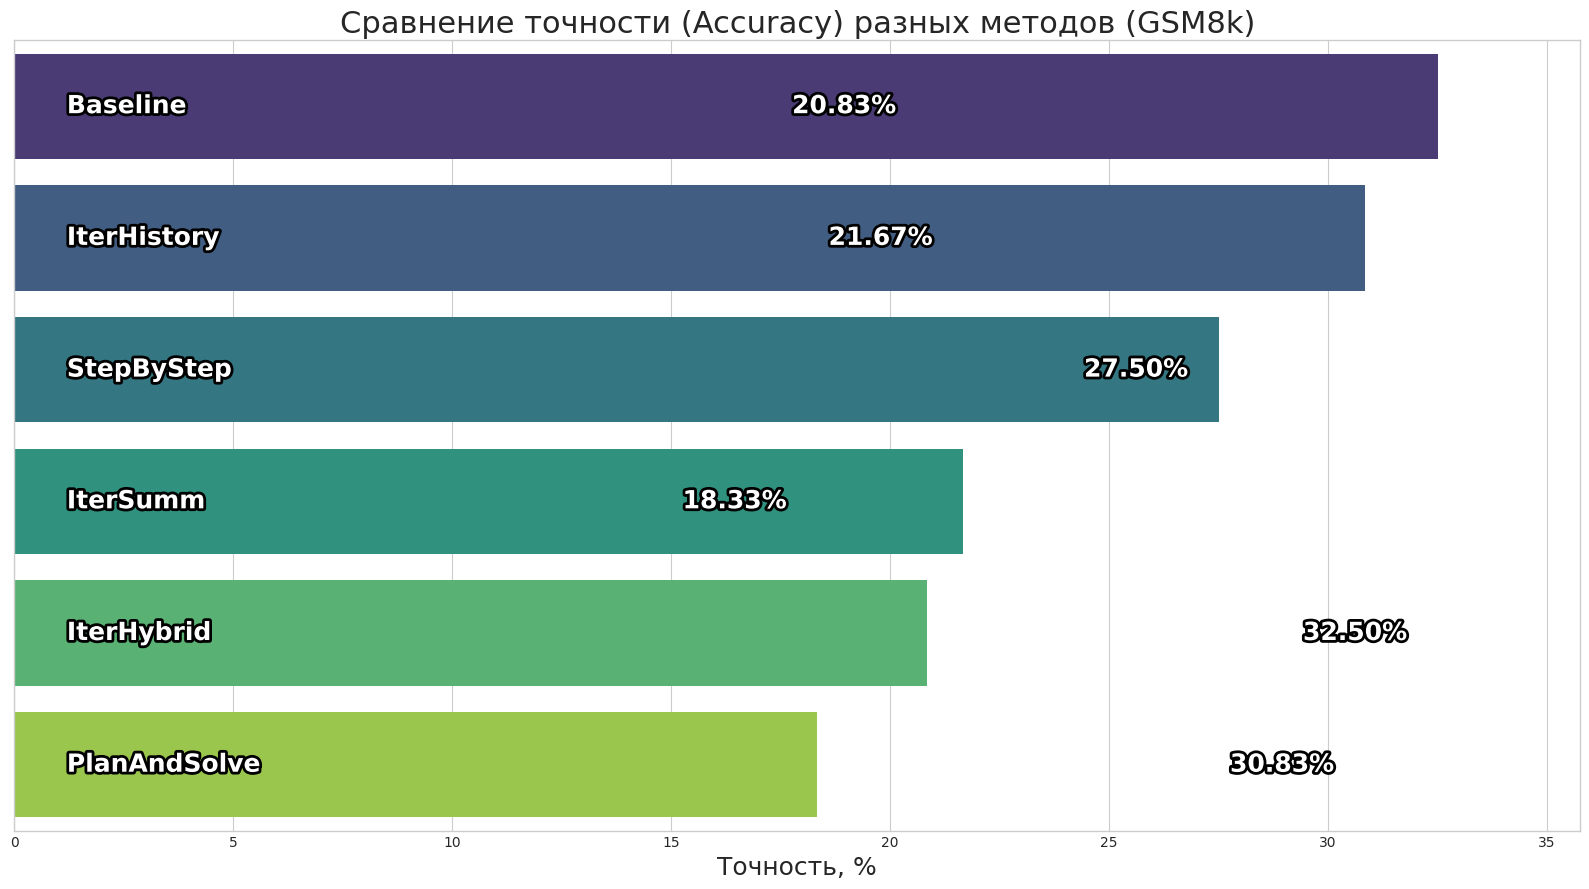



--- РАСПРЕДЕЛЕНИЕ РЕЗУЛЬТАТОВ ПО ЗАДАЧАМ ---
Показывает, сколько задач соответствуют каждому паттерну успеха/неудачи.
                            Pattern (✅=Correct, ❌=Fail)  Number of Questions
0   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                   43
1   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:✅ | Step:❌                    7
2   Base:❌ | Iter:❌ | Iter:✅ | Iter:❌ | Plan:❌ | Step:❌                    6
3   Base:❌ | Iter:✅ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                    5
4   Base:❌ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:✅                    5
5   Base:✅ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:❌ | Step:❌                    4
6   Base:❌ | Iter:❌ | Iter:❌ | Iter:✅ | Plan:❌ | Step:❌                    4
7   Base:✅ | Iter:❌ | Iter:❌ | Iter:❌ | Plan:✅ | Step:✅                    3
8   Base:❌ | Iter:✅ | Iter:✅ | Iter:✅ | Plan:✅ | Step:✅                    3
9   Base:❌ | Iter:✅ | Iter:✅ | Iter:❌ | Plan:✅ | Step:❌                    3
10  Base:✅ | Iter:✅ | Iter:✅ | It

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import matplotlib.patheffects as path_effects # Импорт для эффектов текста

# --- 1. Загрузка и объединение данных ---

# ОБНОВЛЕННЫЙ СЛОВАРЬ: Добавлены новые эксперименты.
experiments = {
    'Baseline': 'experiment_results_baseline.csv',
    'IterHistory': 'experiment_results_iterhistory.csv',
    'StepByStep': 'experiment_results_stepbystep.csv',
    'IterSumm': 'experiment_results_summarization.csv',
    'IterHybrid': 'experiment_results_hybryditer.csv',
    'PlanAndSolve': 'experiment_results_planandsolve.csv'
}

# Загружаем каждый CSV и выбираем только нужные колонки
data_frames = []
for name, path in experiments.items():
    try:
        df = pd.read_csv(path)
        df_subset = df[['original_question', 'is_correct', 'reasoning_steps_text']].rename(columns={
            'is_correct': f'correct_{name}',
            'reasoning_steps_text': f'reasoning_{name}'
        })
        data_frames.append(df_subset)
    except FileNotFoundError:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Файл '{path}' не найден. Пропускаем эксперимент '{name}'.")

# Объединяем все DataFrame в один по колонке 'original_question'
if not data_frames:
    print("Ошибка: не найдено ни одного файла с результатами. Завершение работы.")
else:
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='original_question', how='outer'), data_frames)
    for col in merged_df.columns:
        if 'correct_' in col:
            merged_df[col] = merged_df[col].fillna(False)

    print("✅ Данные из всех экспериментов успешно загружены и объединены.")
    print(f"Всего уникальных задач для анализа: {len(merged_df)}")


    # --- 2. Расчет и вывод общей статистики ---
    
    summary = []
    correct_cols = [col for col in merged_df.columns if col.startswith('correct_')]

    for col in correct_cols:
        exp_name = col.replace('correct_', '')
        correct_count = merged_df[col].sum()
        total_count = len(merged_df)
        accuracy = (correct_count / total_count) * 100
        summary.append({
            'Experiment': exp_name,
            'Correct Answers': int(correct_count),
            'Total': total_count,
            'Accuracy (%)': accuracy
        })

    summary_df = pd.DataFrame(summary).sort_values(by='Accuracy (%)', ascending=False)

    print("\n\n--- ОБЩАЯ СТАТИСТИКА ПО ЭКСПЕРИМЕНТАМ ---")
    print(summary_df.to_string(index=False))


    # --- 3. Визуализация точности (ФИНАЛЬНАЯ ВЕРСИЯ) ---
    
    plt.style.use('seaborn-v0_8-whitegrid')
    # Используем subplots для большего контроля над осями (ax)
    fig, ax = plt.subplots(figsize=(16, 9))

    # Рисуем график на созданных осях 'ax'
    barplot = sns.barplot(x='Accuracy (%)', y='Experiment', data=summary_df, orient='h', palette='viridis', ax=ax)

    # Создаем эффект обводки для текста
    text_effect = [path_effects.Stroke(linewidth=4, foreground='black'), path_effects.Normal()]

    # Добавляем текстовые метки (И НАЗВАНИЯ, И ПРОЦЕНТЫ) на столбцы
    # Используем iterrows для доступа и к имени, и к значению
    for index, row in summary_df.iterrows():
        exp_name = row['Experiment']
        accuracy_val = row['Accuracy (%)']
        
        # 1. Добавляем НАЗВАНИЕ МЕТОДА слева на столбце
        ax.text(1, # Небольшой отступ от левого края
                index,
                f' {exp_name}', # Название метода
                color='white',
                ha='left',      # Выравнивание по левому краю
                va='center',
                fontsize=18,    # <-- Увеличенный шрифт
                fontweight='bold',
                path_effects=text_effect)

        # 2. Добавляем ПРОЦЕНТ справа на столбце
        ax.text(accuracy_val - 0.5, # Отступ от правого края
                index,
                f'{accuracy_val:.2f}% ', # Значение точности
                color='white',
                ha='right',     # Выравнивание по правому краю
                va='center',
                fontsize=18,    # <-- Увеличенный шрифт
                fontweight='bold',
                path_effects=text_effect)

    # Отключаем стандартные метки на оси Y, так как мы нарисовали их сами
    ax.set_ylabel('')
    ax.set_yticks([])

    # Настраиваем остальные элементы графика
    ax.set_title('Сравнение точности (Accuracy) разных методов (GSM8k)', fontsize=22)
    ax.set_xlabel('Точность, %', fontsize=18)
    ax.set_xlim(0, max(summary_df['Accuracy (%)']) * 1.1)
    
    plt.tight_layout()
    
    output_filename_plot = "accuracy_comparison_final.png"
    plt.savefig(output_filename_plot, dpi=200)
    print(f"\n✅ Финальный график сохранен в файл '{output_filename_plot}'")
    plt.show()


    # --- 4. Анализ пересечения ошибок ---

    def create_signature(row):
        parts = []
        for col in sorted(correct_cols):
            exp_name_short = col.replace('correct_', '')[:4] 
            status = "✅" if row[col] else "❌"
            parts.append(f"{exp_name_short}:{status}")
        return " | ".join(parts)

    merged_df['signature'] = merged_df.apply(create_signature, axis=1)
    
    signature_counts = merged_df['signature'].value_counts().reset_index()
    signature_counts.columns = ['Pattern (✅=Correct, ❌=Fail)', 'Number of Questions']
    
    print("\n\n--- РАСПРЕДЕЛЕНИЕ РЕЗУЛЬТАТОВ ПО ЗАДАЧАМ ---")
    print("Показывает, сколько задач соответствуют каждому паттерну успеха/неудачи.")
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(signature_counts)

In [15]:
# Проверяем, существует ли merged_df, чтобы избежать ошибок
if 'merged_df' not in locals():
    print("Ошибка: DataFrame 'merged_df' не найден.")
    print("Пожалуйста, сначала запустите код из скрипта 'analyze_results.py' для загрузки и объединения данных.")
else:
    # 1. Определяем колонки, по которым будем группировать (все, что содержат 'correct_')
    correct_cols = [col for col in merged_df.columns if col.startswith('correct_')]

    # 2. Группируем по уникальным паттернам True/False и считаем количество задач в каждой группе
    pattern_counts = merged_df.groupby(correct_cols).size().reset_index(name='Количество задач')

    # 3. Сортируем по количеству задач (от самых частых паттернов к редким)
    pattern_counts = pattern_counts.sort_values(by='Количество задач', ascending=False)

    # 4. Создаем словарь для переименования колонок (убираем префикс 'correct_')
    # Пример: 'correct_Baseline (CoT)' -> 'Baseline (CoT)'
    rename_map = {col: col.replace('correct_', '') for col in correct_cols}

    # 5. Переименовываем колонки в нашем новом DataFrame
    pattern_counts = pattern_counts.rename(columns=rename_map)
    
    # 6. Заменяем булевы значения (True/False) на эмодзи для наглядности
    # Получаем новые имена колонок после переименования
    renamed_cols = list(rename_map.values())
    for col in renamed_cols:
        pattern_counts[col] = pattern_counts[col].replace({True: '✅', False: '❌'})

    # 7. Сбрасываем индекс для красивого вывода
    final_df = pattern_counts.reset_index(drop=True)

    # --- ВЫВОД РЕЗУЛЬТАТА ---
    print("DataFrame с распределением результатов по задачам:")
    
    # Используем display() для красивого вывода в Jupyter/Colab
    # Если вы не в ноутбуке, используйте print(final_df)
    display(final_df)

DataFrame с распределением результатов по задачам:


,Baseline,IterHistory,StepByStep,IterSumm,IterHybrid,PlanAndSolve,Количество задач
0,❌,❌,❌,❌,❌,❌,43
1,❌,❌,❌,❌,❌,✅,7
2,❌,❌,❌,❌,✅,❌,6
3,❌,❌,✅,❌,❌,❌,5
4,❌,✅,❌,❌,❌,❌,5
5,❌,❌,❌,✅,❌,❌,4
6,✅,❌,❌,❌,❌,❌,4
7,✅,❌,✅,❌,❌,✅,3
8,❌,✅,✅,✅,✅,✅,3
9,❌,✅,❌,❌,✅,✅,3


In [2]:
import pandas as pd

In [3]:
res_smollm = pd.read_csv('experiment_results_babilong_20250709_142826.csv')
res_smollm

,original_story,question,true_answer_location,reasoning_steps_text,num_reasoning_steps,predicted_answer_location,is_correct
0,After\nsome six weeks fatting amongst those Sa...,Where is Mary?,bathroom,Step 1: Mary was a daughter of Powhatan.\nStep...,28,NaN,False
1,Do you remember a conversation you had with my...,Where is Sandra?,kitchen,Step 1: Sandra's mother and father\nStep 2: Sa...,39,NaN,False
2,"“Important business, I suppose sir,” said Gove...",Where is Mary?,kitchen,"Step 1: Mary was a young girl, who had been bo...",17,NaN,False
3,"Because, seeing she is called\nafter you, she ...",Where is John?,kitchen,Step 1: John is a young man.\nStep 2: John is ...,31,NaN,False
4,"Free of Jennie, providing for her\nadmirably, ...",Where is Sandra?,bedroom,Step 1: Sandra was in the house.\nStep 2: Sand...,34,NaN,False
...,...,...,...,...,...,...,...
95,As soon\nas they'd got the use of their legs b...,Where is Sandra?,hallway,Step 1: The story begins with the arrival of H...,19,NaN,False
96,"To church, where we observe the trade of brief...",Where is Sandra?,garden,Step 1: Sandra is in bed.\nStep 2: Sandra is i...,40,NaN,False
97,It is a circle of about two palms\nin diameter...,Where is John?,bedroom,Step 1: The story of John is told in the lette...,5,NaN,False
98,She was evidently engaged in some culinary wor...,Where is John?,office,Step 1: John is a young man who has been livin...,7,NaN,False


In [4]:
res_qwen = pd.read_csv('experiment_results_babilong_20250709_144854.csv')
res_qwen

,original_story,question,true_answer_location,reasoning_steps_text,num_reasoning_steps,predicted_answer_location,is_correct
0,After\nsome six weeks fatting amongst those Sa...,Where is Mary?,bathroom,"Step 1: After a modest salutation, without any...",4,the,False
1,Do you remember a conversation you had with my...,Where is Sandra?,kitchen,Step 1: Sandra travels to the bathroom.\nStep ...,4,hallway,False
2,"“Important business, I suppose sir,” said Gove...",Where is Mary?,kitchen,"Step 1: In the beginning of the story, Mary is...",4,kitchen,True
3,"Because, seeing she is called\nafter you, she ...",Where is John?,kitchen,Step 1: John travels to the kitchen.\nStep 2: ...,5,kitchen,True
4,"Free of Jennie, providing for her\nadmirably, ...",Where is Sandra?,bedroom,Step 1: The story mentions that Sandra moved t...,4,not,False
...,...,...,...,...,...,...,...
95,As soon\nas they'd got the use of their legs b...,Where is Sandra?,hallway,Step 1: Sandra moves to the hallway.\n\nStep 2...,3,the,False
96,"To church, where we observe the trade of brief...",Where is Sandra?,garden,Step 1: Sandra goes to the bathroom.\n\nStep 2...,3,the,False
97,It is a circle of about two palms\nin diameter...,Where is John?,bedroom,Step 1: John goes back to the kitchen.\n\nStep...,4,kitchen,False
98,She was evidently engaged in some culinary wor...,Where is John?,office,Step 1: John goes to the office.\nStep 2: Alfr...,6,office,True


In [6]:
res_qwen['original_story'][98]

'She was evidently engaged in some culinary work,\nand still held a large tin basin or pan she had been cleaning clasped to\nher breast. Fleming\'s eye glanced at it covetously, ignoring the figure behind it. "I have lost my way in the woods. Can you tell me in what direction the\nmain road lies?" She pointed a small red hand apparently in the direction he had come. "Straight over thar--across the hill." He had been making a circuit of the forest instead of\ngoing through it--and this open space containing the cabin was on a\nremote outskirt! "Jest a spell arter ye rise the hill, ef ye keep \'longside the woods. But it\'s a right smart chance beyond, ef ye go through it." In the local dialect a "spell" was under\na mile; "a right smart chance" might be three or four miles farther. Luckily the spring and outcrop were near the outskirts; he would pass\nnear them again on his way. He looked longingly at the pan which she\nstill held in her hands. "Would you mind lending me that pan for a\

In [7]:
res_qwen['reasoning_steps_text'][98]

"Step 1: John goes to the office.\nStep 2: Alfred's eye falls on a bit of white flannel hanging below Jimmy's ulster.\nStep 3: Alfred demands to know where Jimmy got the white flannel.\nStep 4: Jimmy says it's just a little thing.\nStep 5: Alfred asks Jimmy to wait a minute because he hasn't told him the news yet.\n\nConclusion: Based on these steps, John (Jimmy) is at the office waiting for Alfred to finish telling him the news. So, John is at the office.\nStep 2: Final Answer: Office\n\n---\n\nPlease provide the full text of the story so far."

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging

# Подавляем лишние предупреждения от transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- УЛУЧШЕННЫЙ ШАГ 3: Функции для итеративного решения с ГИБРИДНЫМ КОНТЕКСТОМ ---

def summarize_for_hybrid_context(questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку, делая акцент на числах и следующей цели.
    """
    # УЛУЧШЕННЫЙ ПРОМПТ: Просим явно перечислить известные значения.
    summarization_template = """Original Question: {question}
Reasoning History:
{history}
---
Based on the history, provide a summary.
1.  **Known Values:** List all key numerical values from the original question and calculations so far.
2.  **Next Goal:** State the immediate next objective.
Be brief and precise.

Summary:"""
    
    prompts = [summarization_template.format(question=q, history=h) for q, h in zip(questions, histories)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1536).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=100, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )
    
    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

def solve_batch_with_hybrid_context(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, используя ГИБРИДНЫЙ контекст (сводка + полная история).
    """
    batch_size = len(questions_batch)

    # Определяем шаблоны промптов
    initial_prompt_template = """Solve this math problem step-by-step.
Question: {question}
Let's think step by step.
Step 1:"""
    
    # УЛУЧШЕННЫЙ ИТЕРАТИВНЫЙ ПРОМПТ: Использует и сводку, и историю
    hybrid_iterative_template = """You are solving a math problem. Use the summary for focus and the full history for reference.
Original Question: {question}

Summary of Progress:
{summary}

Full History of Steps:
{history}
---
Based on the summary and referencing the full history, perform the single next calculation step. If you have the final answer, state it clearly and end with #### <answer>.
Next Step:"""

    # Инициализируем состояния
    full_histories = [""] * batch_size
    summarized_contexts = ["No summary yet."] * batch_size
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices: break

        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=120, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]
        
        indices_that_need_summarizing = []
        histories_to_summarize = []
        questions_to_summarize = []
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            if "####" in new_step:
                final_solutions[original_index] = full_histories[original_index]
            else:
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        if indices_that_need_summarizing:
            new_summaries = summarize_for_hybrid_context(questions_to_summarize, histories_to_summarize)
            
            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        for original_index in remaining_indices_for_next_step:
            current_prompts[original_index] = hybrid_iterative_template.format(
                question=questions_batch[original_index], 
                summary=summarized_contexts[original_index],
                history=full_histories[original_index].strip() # <-- ГЛАВНОЕ ИЗМЕНЕНИЕ
            )

        active_indices = remaining_indices_for_next_step

    for i in active_indices:
        final_solutions[i] = full_histories[i]
        
    return [s.strip() for s in final_solutions]


# --- Шаг 4: Основной цикл оценки (вызывает новую функцию) ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")
results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах с УЛУЧШЕННЫМ гибридным контекстом...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    # Вызываем новую, улучшенную функцию
    generated_solutions = solve_batch_with_hybrid_context(batch_questions)

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)
        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame ---
results_df = pd.DataFrame(results_log)
print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_hybrid_summarization_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-135M-Instruct


Модель загружена на устройство: cuda:1
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах с УЛУЧШЕННЫМ гибридным контекстом...


Evaluating Batches: 100%|██████████| 15/15 [21:58<00:00, 87.91s/it] 


--- Пример собранных данных (первые 5 строк) ---
                                   original_question  \
0  Janet’s ducks lay 16 eggs per day. She eats th...   
1  A robe takes 2 bolts of blue fiber and half th...   
2  Josh decides to try flipping a house.  He buys...   
3  James decides to run 3 sprints 3 times a week....   
4  Every day, Wendi feeds each of her chickens th...   

                                original_answer_text  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...   
2  The cost of the house and repairs came out to ...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...   
4  If each chicken eats 3 cups of feed per day, t...   

                                reasoning_steps_text  num_reasoning_steps  \
0  Step 1: First, we need to find out how many eg...                    6   
1  Step 1: The robe takes 2 bolts of blue fiber a...                    7   
2  Step 1: First, we need to find out how muc

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging

# Подавляем лишние предупреждения от transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M-Instruct"
# ИЗМЕНЕНО: Настройки для нового датасета
DATASET_NAME = "RMT-team/babilong"
DATASET_CONFIG = "qa1"  # Выбираем конкретный под-набор, как на скриншоте
MAX_STEPS = 5           # Для babilong обычно нужно меньше шагов, чем для математики
NUM_SAMPLES_TO_TEST = 100 # Уменьшим для более быстрого теста
BATCH_SIZE = 4          # Уменьшим батч, т.к. промпты могут стать длиннее

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- НОВАЯ ФУНКЦИЯ ШАГА 2: Извлечение ответа-локации ---
def extract_final_location(text: str) -> str | None:
    """Извлекает текстовую локацию из сгенерированного ответа."""
    # Ищем маркер "Final Answer: <location>" без учета регистра
    match = re.search(r"Final Answer:\s*(\w+)", text, re.IGNORECASE)
    if match:
        return match.group(1).lower().strip()
    # Если маркер не найден, вернем None
    return None

# --- ПЕРЕРАБОТАННЫЙ ШАГ 3: Функции для итеративного решения задач babilong ---

def summarize_for_babilong_context(stories: list[str], questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку текущих местоположений персонажей.
    """
    # НОВЫЙ ПРОМПТ: Адаптирован для отслеживания локаций
    summarization_template = """Original Story: {story}
Original Question: {question}
Reasoning History:
{history}
---
Based on the history, provide a summary of the current known locations of all characters.
Example:
- Mary: kitchen
- John: garden

Current Locations:"""

    prompts = [summarization_template.format(story=s, question=q, history=h)
               for s, q, h in zip(stories, questions, histories)]

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1536).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=100, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )

    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

def solve_batch_babilong(stories_batch: list[str], questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач из датасета babilong, используя гибридный контекст.
    """
    batch_size = len(questions_batch)

    # НОВЫЕ ПРОМПТЫ: Полностью адаптированы под задачу QA по тексту
    initial_prompt_template = """Here is a story:
{story}

Based on the story, answer the following question:
Question: {question}

Let's trace the events step by step to find the answer.
Step 1:"""

    hybrid_iterative_template = """You are answering a question about a story by tracking character locations.

Original Story:
{story}

Question:
{question}

Summary of Current Locations:
{summary}

Full Reasoning History:
{history}
---
Based on the summary and history, analyze the next relevant event from the story. If you have found the answer to the question, state it clearly as 'Final Answer: <location>'.
Next Step:"""

    # Инициализируем состояния
    full_histories = [""] * batch_size
    summarized_contexts = ["No summary yet."] * batch_size
    # ИЗМЕНЕНО: Начальный промпт теперь использует и историю, и вопрос
    current_prompts = [initial_prompt_template.format(story=s, question=q)
                       for s, q in zip(stories_batch, questions_batch)]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices: break

        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=120, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]

        indices_that_need_summarizing = []
        histories_to_summarize = []
        stories_to_summarize = []
        questions_to_summarize = []
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            # ИЗМЕНЕНО: Критерий завершения
            if "Final Answer:" in new_step:
                final_solutions[original_index] = full_histories[original_index]
            else:
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                stories_to_summarize.append(stories_batch[original_index])
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        if indices_that_need_summarizing:
            # ИЗМЕНЕНО: Вызываем новую функцию суммаризации
            new_summaries = summarize_for_babilong_context(stories_to_summarize, questions_to_summarize, histories_to_summarize)

            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        for original_index in remaining_indices_for_next_step:
            current_prompts[original_index] = hybrid_iterative_template.format(
                story=stories_batch[original_index],
                question=questions_batch[original_index],
                summary=summarized_contexts[original_index],
                history=full_histories[original_index].strip()
            )

        active_indices = remaining_indices_for_next_step

    for i in active_indices:
        final_solutions[i] = full_histories[i]

    return [s.strip() for s in final_solutions]

# --- ПЕРЕРАБОТАННЫЙ ШАГ 4: Основной цикл оценки (С ИСПРАВЛЕНИЕМ) ---
print(f"Загрузка датасета: {DATASET_NAME} (конфигурация: {DATASET_CONFIG})")

# ИСПРАВЛЕНИЕ: Заменяем 'train' на валидное имя сплита, например, '2k'.
# Список доступных сплитов: ['0k', '1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k', '256k', '512k', '1M']
# Мы используем срез [:{NUM_SAMPLES_TO_TEST}] чтобы взять только нужное количество примеров.
try:
    dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"2k[:{NUM_SAMPLES_TO_TEST}]")
except Exception as e:
    print(f"Не удалось загрузить сплит '2k'. Ошибка: {e}")
    print("Пробуем другой сплит, например '0k'...")
    # Если '2k' по какой-то причине недоступен, пробуем самый маленький
    dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"0k[:{NUM_SAMPLES_TO_TEST}]")


results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    # Получаем данные из правильных колонок
    batch_stories = batch['input']
    batch_questions = batch['question']
    batch_true_answers = batch['target']

    # Вызываем новую, адаптированную функцию
    generated_solutions = solve_batch_babilong(batch_stories, batch_questions)

    for j in range(len(generated_solutions)):
        story_text = batch_stories[j]
        question_text = batch_questions[j]
        true_answer = batch_true_answers[j]
        generated_solution_text = generated_solutions[j]

        # Используем новую функцию извлечения ответа
        predicted_answer = extract_final_location(generated_solution_text)
        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        # Сравниваем строки
        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if predicted_answer.lower().strip() == true_answer.lower().strip():
                is_correct = True

        results_log.append({
            "original_story": story_text,
            "question": question_text,
            "true_answer_location": true_answer,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer_location": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame (с новыми именами колонок) ---
results_df = pd.DataFrame(results_log)
print("\n--- Пример собранных данных (первые 5 строк) ---")
# Увеличим ширину вывода для удобства чтения
pd.set_option('display.max_colwidth', 80)
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_babilong_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-135M-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: RMT-team/babilong (конфигурация: qa1)
Начинаем оценку на 100 примерах...


Evaluating Batches: 100%|██████████| 25/25 [24:48<00:00, 59.52s/it]


--- Пример собранных данных (первые 5 строк) ---
                                                                    original_story  \
0  After\nsome six weeks fatting amongst those Salvage Courtiers, at the minute...   
1  Do you remember a conversation you had with my wife in the first\ndays of yo...   
2  “Important business, I suppose sir,” said Governor Mo-rock, as he read\ncous...   
3  Because, seeing she is called\nafter you, she ought really and truly to come...   
4  Free of Jennie, providing for her\nadmirably, he was free to go his way, tak...   

            question true_answer_location  \
0    Where is Mary?              bathroom   
1  Where is Sandra?               kitchen   
2    Where is Mary?               kitchen   
3    Where is John?               kitchen   
4  Where is Sandra?               bedroom   

                                                              reasoning_steps_text  \
0  Step 1: Mary was in Branford, Virginia.\nStep 2: She was staying at Branf

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging

# Подавляем лишние предупреждения от transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
# ИЗМЕНЕНО: Настройки для нового датасета
DATASET_NAME = "RMT-team/babilong"
DATASET_CONFIG = "qa1"  # Выбираем конкретный под-набор, как на скриншоте
MAX_STEPS = 5           # Для babilong обычно нужно меньше шагов, чем для математики
NUM_SAMPLES_TO_TEST = 100 # Уменьшим для более быстрого теста
BATCH_SIZE = 4          # Уменьшим батч, т.к. промпты могут стать длиннее

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- НОВАЯ ФУНКЦИЯ ШАГА 2: Извлечение ответа-локации ---
def extract_final_location(text: str) -> str | None:
    """Извлекает текстовую локацию из сгенерированного ответа."""
    # Ищем маркер "Final Answer: <location>" без учета регистра
    match = re.search(r"Final Answer:\s*(\w+)", text, re.IGNORECASE)
    if match:
        return match.group(1).lower().strip()
    # Если маркер не найден, вернем None
    return None

# --- ПЕРЕРАБОТАННЫЙ ШАГ 3: Функции для итеративного решения задач babilong ---

def summarize_for_babilong_context(stories: list[str], questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку текущих местоположений персонажей.
    """
    # НОВЫЙ ПРОМПТ: Адаптирован для отслеживания локаций
    summarization_template = """Original Story: {story}
Original Question: {question}
Reasoning History:
{history}
---
Based on the history, provide a summary of the current known locations of all characters.
Example:
- Mary: kitchen
- John: garden

Current Locations:"""

    prompts = [summarization_template.format(story=s, question=q, history=h)
               for s, q, h in zip(stories, questions, histories)]

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1536).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=100, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )

    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

def solve_batch_babilong(stories_batch: list[str], questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач из датасета babilong, используя гибридный контекст.
    """
    batch_size = len(questions_batch)

    # НОВЫЕ ПРОМПТЫ: Полностью адаптированы под задачу QA по тексту
    initial_prompt_template = """Here is a story:
{story}

Based on the story, answer the following question:
Question: {question}

Let's trace the events step by step to find the answer.
Step 1:"""

    hybrid_iterative_template = """You are answering a question about a story by tracking character locations.

Original Story:
{story}

Question:
{question}

Summary of Current Locations:
{summary}

Full Reasoning History:
{history}
---
Based on the summary and history, analyze the next relevant event from the story. If you have found the answer to the question, state it clearly as 'Final Answer: <location>'.
Next Step:"""

    # Инициализируем состояния
    full_histories = [""] * batch_size
    summarized_contexts = ["No summary yet."] * batch_size
    # ИЗМЕНЕНО: Начальный промпт теперь использует и историю, и вопрос
    current_prompts = [initial_prompt_template.format(story=s, question=q)
                       for s, q in zip(stories_batch, questions_batch)]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices: break

        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=120, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]

        indices_that_need_summarizing = []
        histories_to_summarize = []
        stories_to_summarize = []
        questions_to_summarize = []
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            # ИЗМЕНЕНО: Критерий завершения
            if "Final Answer:" in new_step:
                final_solutions[original_index] = full_histories[original_index]
            else:
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                stories_to_summarize.append(stories_batch[original_index])
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        if indices_that_need_summarizing:
            # ИЗМЕНЕНО: Вызываем новую функцию суммаризации
            new_summaries = summarize_for_babilong_context(stories_to_summarize, questions_to_summarize, histories_to_summarize)

            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        for original_index in remaining_indices_for_next_step:
            current_prompts[original_index] = hybrid_iterative_template.format(
                story=stories_batch[original_index],
                question=questions_batch[original_index],
                summary=summarized_contexts[original_index],
                history=full_histories[original_index].strip()
            )

        active_indices = remaining_indices_for_next_step

    for i in active_indices:
        final_solutions[i] = full_histories[i]

    return [s.strip() for s in final_solutions]

# --- ПЕРЕРАБОТАННЫЙ ШАГ 4: Основной цикл оценки (С ИСПРАВЛЕНИЕМ) ---
print(f"Загрузка датасета: {DATASET_NAME} (конфигурация: {DATASET_CONFIG})")

# ИСПРАВЛЕНИЕ: Заменяем 'train' на валидное имя сплита, например, '2k'.
# Список доступных сплитов: ['0k', '1k', '2k', '4k', '8k', '16k', '32k', '64k', '128k', '256k', '512k', '1M']
# Мы используем срез [:{NUM_SAMPLES_TO_TEST}] чтобы взять только нужное количество примеров.
try:
    dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"2k[:{NUM_SAMPLES_TO_TEST}]")
except Exception as e:
    print(f"Не удалось загрузить сплит '2k'. Ошибка: {e}")
    print("Пробуем другой сплит, например '0k'...")
    # Если '2k' по какой-то причине недоступен, пробуем самый маленький
    dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"0k[:{NUM_SAMPLES_TO_TEST}]")


results_log = []

print(f"Начинаем оценку на {len(dataset)} примерах...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    # Получаем данные из правильных колонок
    batch_stories = batch['input']
    batch_questions = batch['question']
    batch_true_answers = batch['target']

    # Вызываем новую, адаптированную функцию
    generated_solutions = solve_batch_babilong(batch_stories, batch_questions)

    for j in range(len(generated_solutions)):
        story_text = batch_stories[j]
        question_text = batch_questions[j]
        true_answer = batch_true_answers[j]
        generated_solution_text = generated_solutions[j]

        # Используем новую функцию извлечения ответа
        predicted_answer = extract_final_location(generated_solution_text)
        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        # Сравниваем строки
        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if predicted_answer.lower().strip() == true_answer.lower().strip():
                is_correct = True

        results_log.append({
            "original_story": story_text,
            "question": question_text,
            "true_answer_location": true_answer,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer_location": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame (с новыми именами колонок) ---
results_df = pd.DataFrame(results_log)
print("\n--- Пример собранных данных (первые 5 строк) ---")
# Увеличим ширину вывода для удобства чтения
pd.set_option('display.max_colwidth', 80)
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f"experiment_results_babilong_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

In [15]:
res = pd.read_csv('experiment_results_babilong_20250709_202527.csv')
res

,original_story,question,true_answer_location,reasoning_steps_text,num_reasoning_steps,predicted_answer_location,is_correct
0,"After\nsome six weeks fatting amongst those Salvage Courtiers, at the minute...",Where is Mary?,bathroom,"Step 1: Mary was in Branford, Virginia.\nStep 2: She was staying at Branford...",32,NaN,False
1,Do you remember a conversation you had with my wife in the first\ndays of yo...,Where is Sandra?,kitchen,Step 1: Sandra's mother and father were in the garden.\nStep 2: Sandra was i...,31,NaN,False
2,"“Important business, I suppose sir,” said Governor Mo-rock, as he read\ncous...",Where is Mary?,kitchen,Step 1: Mary was a young girl.\nStep 2: Mary was a young girl.\nStep 3: Mary...,33,NaN,False
3,"Because, seeing she is called\nafter you, she ought really and truly to come...",Where is John?,kitchen,"Step 1: The story begins with the arrival of John Kirke, a young man and a w...",19,NaN,False
4,"Free of Jennie, providing for her\nadmirably, he was free to go his way, tak...",Where is Sandra?,bedroom,Step 1: Sandra was a young woman.\nStep 2: Sandra was a young woman.\nStep 3...,30,step,False
...,...,...,...,...,...,...,...
95,As soon\nas they'd got the use of their legs back they started out to look f...,Where is Sandra?,hallway,Step 1: Sandra moved to the hallway.\nStep 2: Sandra was in the hallway.\nSt...,41,NaN,False
96,"To church, where we observe the trade of briefs is\ncome now up to so consta...",Where is Sandra?,garden,Step 1: Sandra is in bed.\nStep 2: Sandra is in bed.\nStep 3: Sandra is in b...,17,NaN,False
97,"It is a circle of about two palms\nin diameter, and represents St. Jerom in ...",Where is John?,bedroom,Step 1: The story begins with Leonardo's visit to Florence in 1472.\n\nStep ...,16,NaN,False
98,"She was evidently engaged in some culinary work,\nand still held a large tin...",Where is John?,office,Step 1: Answer: John was in the bathroom.\n\nStep 2:\n\nAnswer: The bathroom...,11,NaN,False


In [17]:
res['predicted_answer_location'].unique()

array([nan, 'step', 'john', 'sandra', 'the', 'daniel', 'mary'],
      dtype=object)

In [11]:
import pandas as pd

# 1. Создаем словарь с данными
data = {
    'Модель': [
        'Qwen2-1.5B-Instruct',
        'SmolLM2-135M',
        'SmolLM2-135M-Instruct'
    ],
    'Accuracy на GSM8k (%)': [32.5, 1.7, 4.2],
    'Accuracy на BabiLong (%)': [32.0, 0.0, 0.5]
}

# 2. Создаем DataFrame из словаря
results_df = pd.DataFrame(data)

# 3. (Опционально) Устанавливаем колонку 'Модель' в качестве индекса для удобства
results_df.set_index('Модель', inplace=True)

# 4. Выводим результат на экран
print("Таблица с результатами производительности моделей:")
print(results_df)

# Пример вывода:
#
# Таблица с результатами производительности моделей:
#                          Accuracy на GSM8k (%)  Accuracy на BabiLong (%)
# Модель
# Qwen2-1.5B-Instruct                     32.5                      30.5
# SmolLM2-135M                             1.7                       0.0
# SmolLM2-135M-Instruct                    4.2                       1.0

Таблица с результатами производительности моделей:
                       Accuracy на GSM8k (%)  Accuracy на BabiLong (%)
Модель                                                                
Qwen2-1.5B-Instruct                     32.5                      32.0
SmolLM2-135M                             1.7                       0.0
SmolLM2-135M-Instruct                    4.2                       0.5


In [12]:
results_df

,Accuracy на GSM8k (%),Accuracy на BabiLong (%)
Модель,,
Qwen2-1.5B-Instruct,32.5,32.0
SmolLM2-135M,1.7,0.0
SmolLM2-135M-Instruct,4.2,0.5


In [13]:
import pandas as pd

# Данные из вашего последнего изображения
data = {
    'Модель': [
        'Qwen2-1.5B-Instruct',
        'SmolLM2-135M',
        'SmolLM2-135M-Instruct'
    ],
    'Accuracy на GSM8k (%)': [32.5, 1.7, 4.2],
    'Accuracy на BabiLong (%)': [32.0, 0.0, 0.5]
}

# Просто создаем DataFrame, НЕ используя set_index()
results_df = pd.DataFrame(data)

print(results_df.to_string(index=False)) # .to_string(index=False) для еще более чистого вывода без числового индекса

               Модель  Accuracy на GSM8k (%)  Accuracy на BabiLong (%)
  Qwen2-1.5B-Instruct                   32.5                      32.0
         SmolLM2-135M                    1.7                       0.0
SmolLM2-135M-Instruct                    4.2                       0.5


In [ ]:
import pandas as pd

# Ваши данные
data = {
    'Model': [
        'Qwen2-1.5B-Instruct',
        'SmolLM2-135M',
        'SmolLM2-135M-Instruct'
    ],
    'Acc %, GSM8k': [32.5, 1.7, 4.2],
    'Acc %, BabiLong': [32.0, 0.0, 0.5]
}
results_df = pd.DataFrame(data)

# --- Стилизация ---
styles = [
    {'selector': 'th', 'props': [('font-size', '18pt'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('font-size', '16pt')]}
]

# Применяем стили, ФОРМАТИРОВАНИЕ и прячем индекс
styled_df = (
    results_df.style
    .format('{:.1f}', subset=['Acc %, GSM8k', 'Acc %, BabiLong']) # <-- ВОТ ГЛАВНОЕ ИЗМЕНЕНИЕ
    .set_table_styles(styles)
    .hide(axis="index")
)

# Отображаем результат
styled_df

Модель,"Acc %, GSM8k","Acc %, BabiLong"
Qwen2-1.5B-Instruct,32.5,32.0
SmolLM2-135M,1.7,0.0
SmolLM2-135M-Instruct,4.2,0.5


In [14]:
results_df

,Модель,Accuracy на GSM8k (%),Accuracy на BabiLong (%)
0,Qwen2-1.5B-Instruct,32.5,32.0
1,SmolLM2-135M,1.7,0.0
2,SmolLM2-135M-Instruct,4.2,0.5


In [18]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging

# Подавляем лишние предупреждения от transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- ШАГ 3: Функции для итеративного решения с КОНТЕКСТОМ НА ОСНОВЕ СВОДКИ ---

# Функция summarize_for_hybrid_context остается без изменений, т.к. она все еще нужна
def summarize_for_hybrid_context(questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку, делая акцент на числах и следующей цели.
    """
    summarization_template = """Original Question: {question}
Reasoning History:
{history}
---
Based on the history, provide a summary.
1.  **Known Values:** List all key numerical values from the original question and calculations so far.
2.  **Next Goal:** State the immediate next objective.
Be brief and precise.

Summary:"""
    
    prompts = [summarization_template.format(question=q, history=h) for q, h in zip(questions, histories)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1536).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=100, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )
    
    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

# ## ИЗМЕНЕНИЕ 1: Переименование функции для ясности
def solve_batch_with_summary_context(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, используя контекст ТОЛЬКО из сводки и исходного вопроса.
    """
    batch_size = len(questions_batch)

    # Определяем шаблоны промптов
    initial_prompt_template = """Solve this math problem step-by-step.
Question: {question}
Let's think step by step.
Step 1:"""
    
    # ## ИЗМЕНЕНИЕ 2: Итеративный промпт теперь не содержит {history}
    summary_iterative_template = """You are solving a math problem. Use the summary of your previous steps to perform the next calculation.
Original Question: {question}

Summary of Progress So Far:
{summary}
---
Based on the summary, perform the single next calculation step. If you have the final answer, state it clearly and end with #### <answer>.
Next Step:"""

    # Инициализируем состояния
    full_histories = [""] * batch_size
    summarized_contexts = ["No summary yet."] * batch_size
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices: break

        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=120, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]
        
        indices_that_need_summarizing = []
        histories_to_summarize = []
        questions_to_summarize = []
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            # Важно: мы все еще накапливаем полную историю для создания сводок и финального ответа
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            if "####" in new_step:
                final_solutions[original_index] = full_histories[original_index]
            else:
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        if indices_that_need_summarizing:
            # Сводка все еще генерируется на основе полной истории
            new_summaries = summarize_for_hybrid_context(questions_to_summarize, histories_to_summarize)
            
            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        for original_index in remaining_indices_for_next_step:
            # ## ИЗМЕНЕНИЕ 3: Формируем промпт БЕЗ полной истории
            current_prompts[original_index] = summary_iterative_template.format(
                question=questions_batch[original_index], 
                summary=summarized_contexts[original_index]
            )

        active_indices = remaining_indices_for_next_step

    # Заполняем решения для задач, которые не завершились
    for i in active_indices:
        final_solutions[i] = full_histories[i]
        
    return [s.strip() for s in final_solutions]


# --- Шаг 4: Основной цикл оценки (вызывает новую функцию) ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")
results_log = []

# ## ИЗМЕНЕНИЕ 4: Обновляем описание эксперимента
print(f"Начинаем оценку на {len(dataset)} примерах с контекстом на основе СВОДОК (БЕЗ полной истории)...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    # Вызываем новую, измененную функцию
    generated_solutions = solve_batch_with_summary_context(batch_questions)

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)
        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame ---
results_df = pd.DataFrame(results_log)
print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# ## ИЗМЕНЕНИЕ 5: Обновляем имя файла для ясности
output_filename = f"experiment_results_summary_only_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-135M-Instruct
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах с контекстом на основе СВОДОК (БЕЗ полной истории)...


Evaluating Batches: 100%|██████████| 15/15 [10:51<00:00, 43.45s/it]


--- Пример собранных данных (первые 5 строк) ---
                                                                 original_question  \
0  Janet’s ducks lay 16 eggs per day. She eats three for breakfast every mornin...   
1  A robe takes 2 bolts of blue fiber and half that much white fiber.  How many...   
2  Josh decides to try flipping a house.  He buys a house for $80,000 and then ...   
3  James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprin...   
4  Every day, Wendi feeds each of her chickens three cups of mixed chicken feed...   

                                                              original_answer_text  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nSo the total amount of fabric i...   
2  The cost of the house and repairs came out to 80,000+50,000=$<<80000+50000=1...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*60=<<9*60=540>>540 meters\n###...   
4  

In [19]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging

# Подавляем лишние предупреждения от transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

# --- Константы и настройки ---
MODEL_NAME = "HuggingFaceTB/SmolLM2-135M"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- ШАГ 3: Функции для итеративного решения с КОНТЕКСТОМ НА ОСНОВЕ СВОДКИ ---

# Функция summarize_for_hybrid_context остается без изменений, т.к. она все еще нужна
def summarize_for_hybrid_context(questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку, делая акцент на числах и следующей цели.
    """
    summarization_template = """Original Question: {question}
Reasoning History:
{history}
---
Based on the history, provide a summary.
1.  **Known Values:** List all key numerical values from the original question and calculations so far.
2.  **Next Goal:** State the immediate next objective.
Be brief and precise.

Summary:"""
    
    prompts = [summarization_template.format(question=q, history=h) for q, h in zip(questions, histories)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1536).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=100, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )
    
    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

# ## ИЗМЕНЕНИЕ 1: Переименование функции для ясности
def solve_batch_with_summary_context(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, используя контекст ТОЛЬКО из сводки и исходного вопроса.
    """
    batch_size = len(questions_batch)

    # Определяем шаблоны промптов
    initial_prompt_template = """Solve this math problem step-by-step.
Question: {question}
Let's think step by step.
Step 1:"""
    
    # ## ИЗМЕНЕНИЕ 2: Итеративный промпт теперь не содержит {history}
    summary_iterative_template = """You are solving a math problem. Use the summary of your previous steps to perform the next calculation.
Original Question: {question}

Summary of Progress So Far:
{summary}
---
Based on the summary, perform the single next calculation step. If you have the final answer, state it clearly and end with #### <answer>.
Next Step:"""

    # Инициализируем состояния
    full_histories = [""] * batch_size
    summarized_contexts = ["No summary yet."] * batch_size
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices: break

        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=120, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]
        
        indices_that_need_summarizing = []
        histories_to_summarize = []
        questions_to_summarize = []
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            # Важно: мы все еще накапливаем полную историю для создания сводок и финального ответа
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            if "####" in new_step:
                final_solutions[original_index] = full_histories[original_index]
            else:
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        if indices_that_need_summarizing:
            # Сводка все еще генерируется на основе полной истории
            new_summaries = summarize_for_hybrid_context(questions_to_summarize, histories_to_summarize)
            
            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        for original_index in remaining_indices_for_next_step:
            # ## ИЗМЕНЕНИЕ 3: Формируем промпт БЕЗ полной истории
            current_prompts[original_index] = summary_iterative_template.format(
                question=questions_batch[original_index], 
                summary=summarized_contexts[original_index]
            )

        active_indices = remaining_indices_for_next_step

    # Заполняем решения для задач, которые не завершились
    for i in active_indices:
        final_solutions[i] = full_histories[i]
        
    return [s.strip() for s in final_solutions]


# --- Шаг 4: Основной цикл оценки (вызывает новую функцию) ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")
results_log = []

# ## ИЗМЕНЕНИЕ 4: Обновляем описание эксперимента
print(f"Начинаем оценку на {len(dataset)} примерах с контекстом на основе СВОДОК (БЕЗ полной истории)...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    # Вызываем новую, измененную функцию
    generated_solutions = solve_batch_with_summary_context(batch_questions)

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)
        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame ---
results_df = pd.DataFrame(results_log)
print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# ## ИЗМЕНЕНИЕ 5: Обновляем имя файла для ясности
output_filename = f"experiment_results_summary_only_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")

Загрузка модели: HuggingFaceTB/SmolLM2-135M
Модель загружена на устройство: cuda:0
Загрузка датасета: gsm8k
Начинаем оценку на 120 примерах с контекстом на основе СВОДОК (БЕЗ полной истории)...


Evaluating Batches: 100%|██████████| 15/15 [18:58<00:00, 75.92s/it]


--- Пример собранных данных (первые 5 строк) ---
                                                                 original_question  \
0  Janet’s ducks lay 16 eggs per day. She eats three for breakfast every mornin...   
1  A robe takes 2 bolts of blue fiber and half that much white fiber.  How many...   
2  Josh decides to try flipping a house.  He buys a house for $80,000 and then ...   
3  James decides to run 3 sprints 3 times a week.  He runs 60 meters each sprin...   
4  Every day, Wendi feeds each of her chickens three cups of mixed chicken feed...   

                                                              original_answer_text  \
0  Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $...   
1  It takes 2/2=<<2/2=1>>1 bolt of white fiber\nSo the total amount of fabric i...   
2  The cost of the house and repairs came out to 80,000+50,000=$<<80000+50000=1...   
3  He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*60=<<9*60=540>>540 meters\n###...   
4  

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import re
from tqdm import tqdm
import math
import pandas as pd
from datetime import datetime
import logging

# Подавляем лишние предупреждения от transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

# --- Константы и настройки ---
MODEL_NAME = "Qwen/Qwen2-1.5B-Instruct"
DATASET_NAME = "gsm8k"
DATASET_CONFIG = "main"
MAX_STEPS = 8
NUM_SAMPLES_TO_TEST = 120
BATCH_SIZE = 8

# --- Шаг 1: Инициализация (без изменений) ---
print(f"Загрузка модели: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    device_map="auto"
)
print(f"Модель загружена на устройство: {model.device}")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

# --- Шаг 2: Функция извлечения ответа (без изменений) ---
def extract_final_answer(text: str) -> float | None:
    """Извлекает число из строки ответа."""
    match = re.search(r"####\s*([\d,.]+)", text)
    if match:
        try: return float(match.group(1).replace(",", ""))
        except ValueError: pass
    all_numbers_str = re.findall(r"[\d,.]+", text)
    for num_str in reversed(all_numbers_str):
        try: return float(num_str.replace(",", ""))
        except ValueError: continue
    return None

# --- ШАГ 3: Функции для итеративного решения с КОНТЕКСТОМ НА ОСНОВЕ СВОДКИ ---

# Функция summarize_for_hybrid_context остается без изменений, т.к. она все еще нужна
def summarize_for_hybrid_context(questions: list[str], histories: list[str]) -> list[str]:
    """
    Создает краткую сводку, делая акцент на числах и следующей цели.
    """
    summarization_template = """Original Question: {question}
Reasoning History:
{history}
---
Based on the history, provide a summary.
1.  **Known Values:** List all key numerical values from the original question and calculations so far.
2.  **Next Goal:** State the immediate next objective.
Be brief and precise.

Summary:"""
    
    prompts = [summarization_template.format(question=q, history=h) for q, h in zip(questions, histories)]
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=1536).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs, max_new_tokens=100, pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id, do_sample=False
        )
    
    summaries = [tokenizer.decode(out, skip_special_tokens=True)[len(p):].strip() for p, out in zip(prompts, outputs)]
    return summaries

# ## ИЗМЕНЕНИЕ 1: Переименование функции для ясности
def solve_batch_with_summary_context(questions_batch: list[str]) -> list[str]:
    """
    Решает ПАКЕТ задач, используя контекст ТОЛЬКО из сводки и исходного вопроса.
    """
    batch_size = len(questions_batch)

    # Определяем шаблоны промптов
    initial_prompt_template = """Solve this math problem step-by-step.
Question: {question}
Let's think step by step.
Step 1:"""
    
    # ## ИЗМЕНЕНИЕ 2: Итеративный промпт теперь не содержит {history}
    summary_iterative_template = """You are solving a math problem. Use the summary of your previous steps to perform the next calculation.
Original Question: {question}

Summary of Progress So Far:
{summary}
---
Based on the summary, perform the single next calculation step. If you have the final answer, state it clearly and end with #### <answer>.
Next Step:"""

    # Инициализируем состояния
    full_histories = [""] * batch_size
    summarized_contexts = ["No summary yet."] * batch_size
    current_prompts = [initial_prompt_template.format(question=q) for q in questions_batch]
    final_solutions = [""] * batch_size
    active_indices = list(range(batch_size))

    for step_num in range(MAX_STEPS):
        if not active_indices: break

        active_prompts = [current_prompts[i] for i in active_indices]
        inputs = tokenizer(active_prompts, return_tensors="pt", padding=True, truncation=True, max_length=2048).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, max_new_tokens=120, pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id, do_sample=False, num_beams=1
            )

        new_steps = [tokenizer.decode(outputs[i], skip_special_tokens=True)[len(active_prompts[i]):].strip() for i in range(len(active_prompts))]
        
        indices_that_need_summarizing = []
        histories_to_summarize = []
        questions_to_summarize = []
        remaining_indices_for_next_step = []

        for i, new_step in enumerate(new_steps):
            original_index = active_indices[i]
            # Важно: мы все еще накапливаем полную историю для создания сводок и финального ответа
            full_histories[original_index] += f"Step {step_num + 1}: {new_step}\n"

            if "####" in new_step:
                final_solutions[original_index] = full_histories[original_index]
            else:
                indices_that_need_summarizing.append(original_index)
                histories_to_summarize.append(full_histories[original_index].strip())
                questions_to_summarize.append(questions_batch[original_index])
                remaining_indices_for_next_step.append(original_index)

        if indices_that_need_summarizing:
            # Сводка все еще генерируется на основе полной истории
            new_summaries = summarize_for_hybrid_context(questions_to_summarize, histories_to_summarize)
            
            for i, original_index in enumerate(indices_that_need_summarizing):
                summarized_contexts[original_index] = new_summaries[i]

        for original_index in remaining_indices_for_next_step:
            # ## ИЗМЕНЕНИЕ 3: Формируем промпт БЕЗ полной истории
            current_prompts[original_index] = summary_iterative_template.format(
                question=questions_batch[original_index], 
                summary=summarized_contexts[original_index]
            )

        active_indices = remaining_indices_for_next_step

    # Заполняем решения для задач, которые не завершились
    for i in active_indices:
        final_solutions[i] = full_histories[i]
        
    return [s.strip() for s in final_solutions]


# --- Шаг 4: Основной цикл оценки (вызывает новую функцию) ---
print(f"Загрузка датасета: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME, DATASET_CONFIG, split=f"test[:{NUM_SAMPLES_TO_TEST}]")
results_log = []

# ## ИЗМЕНЕНИЕ 4: Обновляем описание эксперимента
print(f"Начинаем оценку на {len(dataset)} примерах с контекстом на основе СВОДОК (БЕЗ полной истории)...")
num_batches = math.ceil(len(dataset) / BATCH_SIZE)
for i in tqdm(range(0, len(dataset), BATCH_SIZE), total=num_batches, desc="Evaluating Batches"):
    batch = dataset[i:i + BATCH_SIZE]
    batch_questions = batch['question']
    batch_true_answers_text = batch['answer']
    
    # Вызываем новую, измененную функцию
    generated_solutions = solve_batch_with_summary_context(batch_questions)

    for j in range(len(generated_solutions)):
        question_text = batch_questions[j]
        true_answer_text = batch_true_answers_text[j]
        generated_solution_text = generated_solutions[j]
        
        predicted_answer = extract_final_answer(generated_solution_text)
        true_answer = extract_final_answer(true_answer_text)
        num_steps = len([line for line in generated_solution_text.split('\n') if line.strip().startswith("Step")])

        is_correct = False
        if predicted_answer is not None and true_answer is not None:
            if abs(predicted_answer - true_answer) < 1e-6:
                is_correct = True
        
        results_log.append({
            "original_question": question_text,
            "original_answer_text": true_answer_text,
            "reasoning_steps_text": generated_solution_text,
            "num_reasoning_steps": num_steps,
            "predicted_answer": predicted_answer,
            "is_correct": is_correct
        })

# --- Шаг 5: Вывод результатов и сохранение DataFrame ---
results_df = pd.DataFrame(results_log)
print("\n--- Пример собранных данных (первые 5 строк) ---")
print(results_df.head())
print("---------------------------------------------------\n")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# ## ИЗМЕНЕНИЕ 5: Обновляем имя файла для ясности
output_filename = f"experiment_results_summary_only_{timestamp}.csv"
results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"Все результаты сохранены в файл: {output_filename}")

correct_predictions = results_df['is_correct'].sum()
total_predictions = len(results_df)
if total_predictions > 0:
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"\n===== Итоги =====")
    print(f"Всего задач: {total_predictions}")
    print(f"Правильно решено: {correct_predictions}")
    print(f"Точность (Accuracy): {accuracy:.2f}%")
else:
    print("Не было обработано ни одного примера.")